# Example 5. Uncalibrated modulators: Oblique plane structured illumination microscopy

Load raw [oblique plane structured illumination microscopy (OPSIM)](https://www.biorxiv.org/content/10.1101/2022.05.19.492671v1.full), process data for rotation and registration, determine SIM pattern infromation, and run reconstruction.

Instrument designed and built by Bingying Chen, Bo-Jui Chang, and Reto Fiolka.  
Cardiomyocyte cell samples labeled for alpha-actinin 2 by James Hayes and Dylan Burnette.   
All imaging by Reto Fiolka. 

### Download data from Zenodo and extract

Data available from [OPSIM Zenodo repository](https://zenodo.org/record/6481084#.YmVM-7lOmHs).  Please download and extract "1_CH00_000000.tif" into data/example_005/raw_data. Once this is done, you can run this example.

### Import libraries

In [1]:
import numpy as np
from numpy import fft
from pathlib import Path
import mcsim.analysis.sim_reconstruction as sim
from mcsim.analysis import analysis_tools
from localize_psf import rois
import matplotlib.pyplot as plt
from matplotlib.colors import PowerNorm
from skimage.transform import rotate, EuclideanTransform, warp
from skimage.registration import phase_cross_correlation
import napari
import tifffile
import gc
from example005_resources.deskew_opm_data import deskew
import itk

### Define data paths to raw OPSIM stack and 2D PSF extracted from many beads

In [2]:
opsim_file_path = Path("data", "example_005", "raw_data", "1_CH00_000000.tif")
psf_file_path = Path("example005_resources", "psf2d.tif")

### Define experimental metadata

In [16]:
# extracted from text file provided with acquisition
n_colors = 1
n_angles = 3
n_phases = 3
ns = 220
ny = 256
nx = 896
pixel_size = 0.114 # um
ds = 0.320 # um - scan step size, not coverslip z
na = 1.0 # Snouty NA
excitation_wavelengths = 0.488 # um
emission_wavelengths = 0.580 # um
tilt_angle = 45.0

# transformed pixel spacing. qi2lab deskew deskews onto an isotropic grid in xy
coverslip_dz = pixel_size * np.sin(tilt_angle)
coverslip_dy = pixel_size
coverslip_dx = pixel_size

### Load and parse data into angles and phases

In [17]:
# create array to hold all raw opsim images
sim_images = np.zeros((n_colors,n_angles,n_phases,ns,ny,nx),dtype=np.uint16)

# loop through TIFF file and load each raw opsim image into proper metadata location
page_idx = 0
with tifffile.TiffFile(opsim_file_path) as tif:
    n_pages = len(tif.pages)
    for channel_idx in range(n_colors):
        for angle_idx in range(n_angles):
            for phase_idx in range(n_phases):
                for scan_idx in range(ns):
                    sim_images[channel_idx,angle_idx,phase_idx,scan_idx,:,:] = tif.pages[page_idx].asarray()
                    page_idx = page_idx + 1

### Visualize OPM SIM data in native reference frame

In [5]:
# add images to napari viewer with scale information
viewer = napari.view_image(sim_images,name='Raw OPSIM data',scale=(1,1,1,ds,pixel_size,pixel_size))

# activate scale bar in physical units
viewer.scale_bar.unit = 'um'
viewer.scale_bar.visible = True

# label sliders in napari viewer
viewer.dims.axis_labels = ['c','a','p','s','y','x']

### Calculate deskewed widefield equivalent images for registration
  
Orthogonal deskew function for OPM extracted from [qi2lab OPM package](https://www.github.com/qi2lab/opm). 

In [18]:
# deskew one channel/angle/phase to get the size of the image
test_deskew = deskew(sim_images[0,0,0,:],tilt_angle,ds,pixel_size)
n_coverslip_z = test_deskew.shape[0]
n_coverslip_y = test_deskew.shape[1]
n_coverslip_x = test_deskew.shape[2]
coverslip_wf_images = np.zeros((n_colors,n_angles,n_coverslip_z,n_coverslip_y,n_coverslip_x),dtype=np.uint16)

# perform deskewing for all widefield equivalent views (average over phases)
for channel_idx in range(n_colors):
    for angle_idx in range(n_angles):
            image_plane = deskew(np.flipud(np.nanmean(sim_images[channel_idx,angle_idx,:,:,:,:],axis=0)),tilt_angle,ds,pixel_size)
            coverslip_wf_images[channel_idx,angle_idx,:] = image_plane

# clean up variables
del test_deskew
gc.collect()

638

### Rotate deskewed widefield equivalent images with prior info from instrument

In [19]:
# pad images to be square
max_size = np.maximum(n_coverslip_y,n_coverslip_x)

if max_size > n_coverslip_y:
    pad_amount_y = np.abs(max_size-n_coverslip_y)//2
else:
    pad_amount_y = 0
if max_size > n_coverslip_x:
    pad_amount_x = np.abs(max_size-n_coverslip_x)//2
else:
    pad_amount_x = 0

pad_width = ((0,0),(0,0),(0,0),(pad_amount_y,pad_amount_y+1),(pad_amount_x,pad_amount_x))

coverslip_rotated_wf_images = np.pad(coverslip_wf_images,pad_width=pad_width)

# rotation angle guesses from instrument design
rotation = [60,0,-60]

# perform rotation across all z planes for each channel + angle
for channel_idx in range(n_colors):
    for angle_idx in range(n_angles):
        for z_idx in range(n_coverslip_z):
            rotated_plane = rotate(coverslip_rotated_wf_images[channel_idx,angle_idx,z_idx,:,:],
                                    angle=rotation[angle_idx],
                                    center=None,
                                    resize=False,
                                    mode='constant',
                                    cval=0,
                                    preserve_range=True)
            coverslip_rotated_wf_images[channel_idx,angle_idx,z_idx,:,:] = rotated_plane

# clean up variables
del coverslip_wf_images
gc.collect()

0

### Visualize rotated widefield equivalent images

In [20]:
# add images to napari viewer with scale information
viewer = napari.view_image(coverslip_rotated_wf_images,name='Rotated Widefield equivalent',scale=(1,1,coverslip_dz,coverslip_dy,coverslip_dx))

# activate scale bar in physical units
viewer.scale_bar.unit = 'um'
viewer.scale_bar.visible = True

# label sliders in napari viewer
viewer.dims.axis_labels = ['c','a','z','y','x']

### Determine image registration in coverslip reference frame using deskewed and rotated widefield equivalent images

In [21]:
# if ITK-elastix results are not satisfactory, set this flag to True to attempt an initial pre-registration using phase correlation
# initital value should be False
perform_initial_phase_correlation_registration = False

# optional phase correlation
if perform_initial_phase_correlation_registration:
    
    # Register using scikit-image
    # Create intial guess for translation based on phase-correlation and max projection images
    # +60 angle (angle_idx = 0) to 0 angle (angle_idx = 1)
    shifts_a000, _, _ = phase_cross_correlation(coverslip_rotated_wf_images[channel_idx,1,:],coverslip_rotated_wf_images[channel_idx,0,:])
    tform_a000 = EuclideanTransform(
        rotation= 0,
        translation = (shifts_a000[2], shifts_a000[1])
        )
    for z_idx in range(n_coverslip_z):
        coverslip_rotated_wf_images[channel_idx,0,z_idx,:]=warp(coverslip_rotated_wf_images[channel_idx,0,z_idx,:], tform_a000.inverse, preserve_range=True)

    # -60 angle (angle_idx = 2) to 0 angle (angle_idx = 1)
    shifts_a002, _, _ = phase_cross_correlation(coverslip_rotated_wf_images[channel_idx,1,:],coverslip_rotated_wf_images[channel_idx,2,:])
    tform_a002 = EuclideanTransform(
        rotation= 0,
        translation = (shifts_a002[2], shifts_a002[1])
        )
    for z_idx in range(n_coverslip_z):
        coverslip_rotated_wf_images[channel_idx,2,z_idx,:]=warp(coverslip_rotated_wf_images[channel_idx,2,z_idx,:], tform_a002.inverse, preserve_range=True)

# Register using ITK-elastix
# create ITK array for fixed view
# itk-elastix currently supports np.float32 only
channel_idx = 0
angle_idx = 1
fixed_image_a001 = itk.GetImageFromArray(coverslip_rotated_wf_images[channel_idx,angle_idx,:].astype(np.float32))

# first, perform translation registration
parameter_object = itk.ParameterObject.New()
default_translation_parameter_map = parameter_object.GetDefaultParameterMap('translation',6)
default_translation_parameter_map['FinalBSplineInterpolationOrder'] = ['2']
parameter_object.AddParameterMap(default_translation_parameter_map)

# second, perform rigid registration
default_rigid_parameter_map = parameter_object.GetDefaultParameterMap('rigid',6)
default_rigid_parameter_map['FinalBSplineInterpolationOrder'] = ['2']
parameter_object.AddParameterMap(default_rigid_parameter_map)

# third, perform affine registration
default_affine_parameter_map = parameter_object.GetDefaultParameterMap('affine',6)
default_affine_parameter_map['FinalBSplineInterpolationOrder'] = ['2']
parameter_object.AddParameterMap(default_affine_parameter_map)

# Call registration functions to determine registration of rotated view (angle_idx=[0,2]) to center view (angle_idx=1)

# create ITK array for +60 rotated view
# itk-elastix currently supports np.float32 only
angle_idx = 0
moving_image_a000 = itk.GetImageFromArray(coverslip_rotated_wf_images[channel_idx,angle_idx,:].astype(np.float32))

# run translation->rigid->affine registration for angle_idx=0
result_image_a000, result_transform_parameters_a000_to_a001 = itk.elastix_registration_method(
    fixed_image_a001, moving_image_a000,
    parameter_object=parameter_object,
    log_to_console=False)

# clean up variables for +60 rotated view
del moving_image_a000
gc.collect()

# create ITK array for -60 rotated view
# itk-elastix currently supports np.float32 only
angle_idx = 2
moving_image_a002 = itk.GetImageFromArray(coverslip_rotated_wf_images[channel_idx,angle_idx,:].astype(np.float32))

# run translation->rigid->affine registration for angle_idx=2
result_image_a002, result_transform_parameters_a002_to_a001 = itk.elastix_registration_method(
    fixed_image_a001, moving_image_a002,
    parameter_object=parameter_object,
    log_to_console=False)

# clean up variables for -60 rotated view
del moving_image_a002
gc.collect()


0

### Visualize results of registration on deskewed widefield equivalent images
If registration results are not satisfactory, change `perform_initial_phase_correlation_registration` in above code block to `True` and re-run registration.

### Visualize registered rotated deskewed widefield equivalent images

In [22]:
# add images to napari viewer with scale information
viewer = napari.view_image(result_image_a000,name='Registered deskewed angle 0',scale=(coverslip_dz,coverslip_dy,coverslip_dx),blending='additive',contrast_limits=[0,np.percentile(result_image_a000, 99.99)])
viewer.add_image(fixed_image_a001,name='Registered deskewed angle 1',scale=(coverslip_dz,coverslip_dy,coverslip_dx),blending='additive',contrast_limits=[0,np.percentile(fixed_image_a001, 99.99)])
viewer.add_image(result_image_a002,name='Registered deskewed angle 2',scale=(coverslip_dz,coverslip_dy,coverslip_dx),blending='additive',contrast_limits=[0,np.percentile(result_image_a002, 99.99)])

# activate scale bar in physical units
viewer.scale_bar.unit = 'um'
viewer.scale_bar.visible = True

# label sliders in napari viewer
viewer.dims.axis_labels = ['z','y','x']

### Deskew all raw OPSIM images

In [23]:
# deskew one channel/angle/phase to get the size of the image
test_deskew = deskew(sim_images[0,0,0,:],tilt_angle,ds,pixel_size)
n_coverslip_z = test_deskew.shape[0]
n_coverslip_y = test_deskew.shape[1]
n_coverslip_x = test_deskew.shape[2]

# create array to hold all deskewed images
coverslip_opsim_images = np.zeros((n_colors,n_angles,n_phases,n_coverslip_z,n_coverslip_y,n_coverslip_x),dtype=np.uint16)

# perform deskewing for all raw opsim views
for channel_idx in range(n_colors):
    for angle_idx in range(n_angles):
        for phase_idx in range(n_phases):
            coverslip_opsim_images[channel_idx,angle_idx,phase_idx,:] = deskew(np.flipud(sim_images[channel_idx,angle_idx,phase_idx,:,:,:]),tilt_angle,ds,pixel_size)

# clean up variables
del test_deskew, sim_images
gc.collect()

33041

### Rotate deskewed raw OPSIM images

In [24]:
# pad images to be square to hold rotated images
max_size = np.maximum(n_coverslip_y,n_coverslip_x)

if max_size > n_coverslip_y:
    pad_amount_y = np.abs(max_size-n_coverslip_y)//2
else:
    pad_amount_y = 0
if max_size > n_coverslip_x:
    pad_amount_x = np.abs(max_size-n_coverslip_x)//2
else:
    pad_amount_x = 0

pad_width = ((0,0),(0,0),(0,0),(0,0),(pad_amount_y,pad_amount_y+1),(pad_amount_x,pad_amount_x))
rotated_coverslip_opsim_images = np.pad(coverslip_opsim_images,pad_width=pad_width)

# rotation angle guesses from instrument design
rotation = [60,0,-60]

# perform rotation across all z planes for each channel + angle
for channel_idx in range(n_colors):
    for angle_idx in range(n_angles):
        for phase_idx in range(n_phases):
            for z_idx in range(n_coverslip_z):
                rotated_plane = rotate(rotated_coverslip_opsim_images[channel_idx,angle_idx,phase_idx,z_idx,:,:],
                                        angle=rotation[angle_idx],
                                        center=None,
                                        resize=False,
                                        mode='constant',
                                        cval=0,
                                        preserve_range=True)
                rotated_coverslip_opsim_images[channel_idx,angle_idx,phase_idx,z_idx,:,:] = rotated_plane

# clean up variables
del coverslip_opsim_images
gc.collect()

0

### Register the rotated deskewed raw OPSIM images using transformation matrices found using rotated deskewed widefield equivalent images

In [25]:
# create temporary variable to hold results of initial translation warp
result_image_translation = np.zeros_like(rotated_coverslip_opsim_images[0,0,0,:])

# loop over all channel/angle/phase and apply transformations for angle_idx=[0,2] to angle_idx=1
for channel_idx in range(n_colors):
    for angle_idx in range(n_angles):
        for phase_idx in range(n_phases):
            if angle_idx == 0:
                if perform_initial_phase_correlation_registration:
                    for z_idx in range(n_coverslip_z):
                        result_image_translation[z_idx,:]=warp(rotated_coverslip_opsim_images[channel_idx,angle_idx,phase_idx,z_idx,:,:], tform_a000.inverse, preserve_range=True)
                    result_image_transformix = itk.transformix_filter(result_image_translation.astype(np.float32),result_transform_parameters_a000_to_a001)
                else:
                    result_image_transformix = itk.transformix_filter(rotated_coverslip_opsim_images[channel_idx,angle_idx,phase_idx,:].astype(np.float32),result_transform_parameters_a000_to_a001)
                rotated_coverslip_opsim_images[channel_idx,angle_idx,phase_idx,:,:,:]=result_image_transformix.astype(np.uint16)
            elif angle_idx == 2:
                if perform_initial_phase_correlation_registration:
                    for z_idx in range(n_coverslip_z):
                        result_image_translation[z_idx,:]=warp(rotated_coverslip_opsim_images[channel_idx,angle_idx,phase_idx,z_idx,:,:], tform_a002.inverse, preserve_range=True)
                    result_image_transformix = itk.transformix_filter(result_image_translation.astype(np.float32),result_transform_parameters_a002_to_a001)
                else:
                    result_image_transformix = itk.transformix_filter(rotated_coverslip_opsim_images[channel_idx,angle_idx,phase_idx,:].astype(np.float32),result_transform_parameters_a002_to_a001)
                rotated_coverslip_opsim_images[channel_idx,angle_idx,phase_idx,:,:,:]=result_image_transformix.astype(np.uint16)

del result_image_translation, result_image_transformix

### Visualize registered rotated deskewed raw OPSIM images

In [26]:
# Set to 'False' to view images in pixel space. Can be helpful to determine ROI
scale = False

if scale:
    # add images to napari viewer with scale information
    viewer = napari.view_image(rotated_coverslip_opsim_images[0,0,:],name='Registered deskewed angle 0',scale=(1,coverslip_dz,coverslip_dy,coverslip_dx),blending='additive',contrast_limits=[0,np.percentile(rotated_coverslip_opsim_images[0,0,:], 99.99)])
    viewer.add_image(rotated_coverslip_opsim_images[0,1,:],name='Registered deskewed angle 1',scale=(1,coverslip_dz,coverslip_dy,coverslip_dx),blending='additive',contrast_limits=[0,np.percentile(rotated_coverslip_opsim_images[0,1,:], 99.99)])
    viewer.add_image(rotated_coverslip_opsim_images[0,2,:],name='Registered deskewed angle 2',scale=(1,coverslip_dz,coverslip_dy,coverslip_dx),blending='additive',contrast_limits=[0,np.percentile(rotated_coverslip_opsim_images[0,2,:], 99.99)])
else:
    viewer = napari.view_image(rotated_coverslip_opsim_images[0,0,:],name='Registered deskewed angle 0',scale=(1,1,1,1),blending='additive',contrast_limits=[0,np.percentile(rotated_coverslip_opsim_images[0,0,:], 99.99)])
    viewer.add_image(rotated_coverslip_opsim_images[0,1,:],name='Registered deskewed angle 1',scale=(1,1,1,1),blending='additive',contrast_limits=[0,np.percentile(rotated_coverslip_opsim_images[0,1,:], 99.99)])
    viewer.add_image(rotated_coverslip_opsim_images[0,2,:],name='Registered deskewed angle 2',scale=(1,1,1,1),blending='additive',contrast_limits=[0,np.percentile(rotated_coverslip_opsim_images[0,2,:], 99.99)])


# activate scale bar in physical units
viewer.scale_bar.unit = 'um'
viewer.scale_bar.visible = True

# label sliders in napari viewer
viewer.dims.axis_labels = ['c','a','p','z','y','x']

### Set ROI to middle of registered rotated deskewed raw OPSIM images and extract crop

In [40]:
# set yx width of ROI
roi_sy=409
roi_sx=409
center_y = 380
center_x = 410
roi = rois.get_centered_roi([center_y, center_x], [roi_sy, roi_sx])

# set these using the z slices that contain data from the Napari preview window above
z_roi_low = 45
z_roi_high = 130

# extract crop
opsim_images_to_process = rotated_coverslip_opsim_images[:,:,:,z_roi_low:z_roi_high,roi[0]:roi[1],roi[2]:roi[3]]

# extract shape of cropped data
nz_cropped = opsim_images_to_process.shape[3]
ny_cropped = opsim_images_to_process.shape[4]
nx_cropped = opsim_images_to_process.shape[5]

### Visualize cropped registered rotated deskewed raw OPSIM images to pick "best" slice

In [38]:
# add images to napari viewer with scale information
viewer = napari.view_image(opsim_images_to_process[0,0,:],name='Registered deskewed angle 0',scale=(1,coverslip_dz,coverslip_dy,coverslip_dx),blending='additive',contrast_limits=[0,np.percentile(opsim_images_to_process[0,0,:], 99.99)])
viewer.add_image(opsim_images_to_process[0,1,:],name='Registered deskewed angle 1',scale=(1,coverslip_dz,coverslip_dy,coverslip_dx),blending='additive',contrast_limits=[0,np.percentile(opsim_images_to_process[0,1,:], 99.99)])
viewer.add_image(opsim_images_to_process[0,2,:],name='Registered deskewed angle 2',scale=(1,coverslip_dz,coverslip_dy,coverslip_dx),blending='additive',contrast_limits=[0,np.percentile(opsim_images_to_process[0,2,:], 99.99)])

# activate scale bar in physical units
viewer.scale_bar.unit = 'um'
viewer.scale_bar.visible = True

# label sliders in napari viewer
viewer.dims.axis_labels = ['c','a','p','z','y','x']

### Find SIM peaks for each angle using test z slice
See [this section of the I2K mcSIM tutorial](https://youtu.be/mDar-MjMtW0?t=6421) video and our [Nikon N-SIM processing tutorial](https://github.com/QI2lab/I2K2022-SIM/blob/0660281c28a809fdc09c36b00903b9230feb4d9c/example_004_Nikon_NSIM.ipynb) for how use the code block to find SIM frequencies.

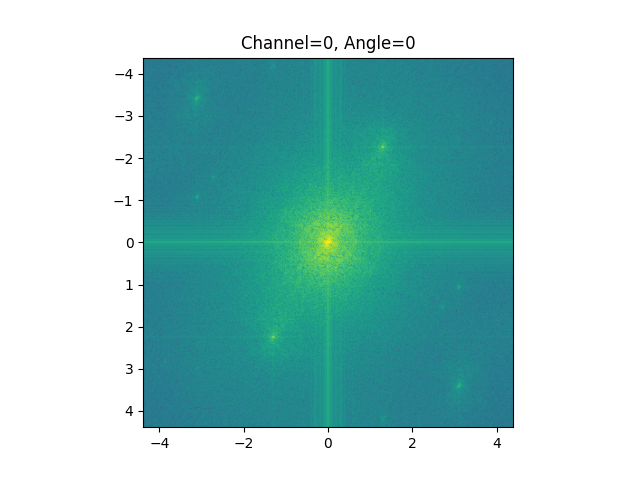

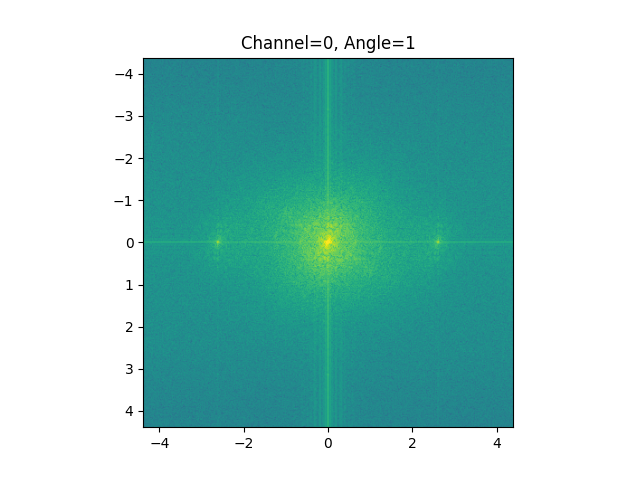

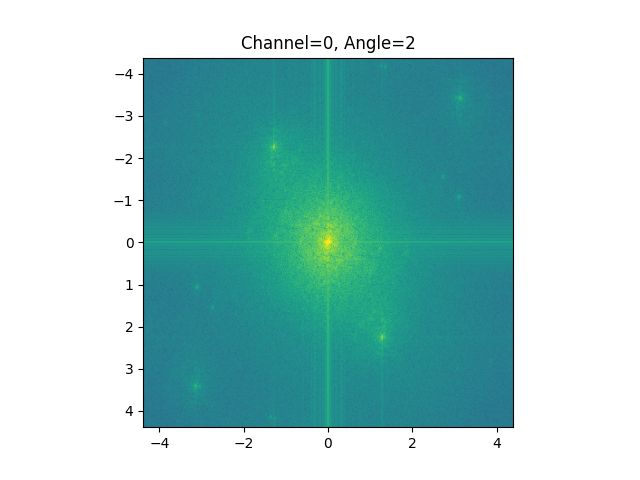

In [41]:
%matplotlib widget

# set "test" slice as determined from data
# chose a z slice with lots of data so that the SIM peaks are visible
z_test_idx=17

for ch_idx in range(n_colors):

    # extract images
    image_set = opsim_images_to_process[ch_idx,:,:,z_test_idx,:,:]

    # calculate FFTs on grid with correct spatial dimensions
    dx = np.round(coverslip_dx,3)
    dy = np.round(coverslip_dy,3)
    nx = nx_cropped
    ny = ny_cropped
    fxs = analysis_tools.get_fft_frqs(nx, dx)
    df = fxs[1] - fxs[0]
    fys = analysis_tools.get_fft_frqs(ny, dy)
    ff = np.sqrt(np.expand_dims(fxs, axis=0)**2 + np.expand_dims(fys, axis=1)**2)
    for ii in range(image_set.shape[0]):
        ft = fft.fftshift(fft.fft2(fft.ifftshift(np.squeeze(image_set[ii, 0, :]))))

        figh = plt.figure()
        plt.title('Channel='+str(ch_idx)+", Angle="+str(ii))
        plt.imshow(np.abs(ft), norm=PowerNorm(gamma=0.1,vmin=65,vmax=1.5e7),
                    extent=[fxs[0] - 0.5 * df, fxs[-1] + 0.5 * df, fys[-1] + 0.5 * df, fys[0] - 0.5 * df])
        plt.show()

### Setup 2D-SIM processing

It is critical to set the initial guesses for SIM peaks correctly in `frqs_guess`. Double check results using diagnostic output plots.

In [43]:
# frequency guess from above. in k_x, k_y order
# getting these as close as possible is critical to reconstruction quality!
frq_guess = [[-1.28,2.25], [-2.6,-0.003], [-1.28,-2.24]]

# phase guesses from prior knowledge
phase_guess = [[0, -4*np.pi/3,-2*np.pi/3], [0, -4*np.pi/3,-2*np.pi/3], [0, -4*np.pi/3,-2*np.pi/3]]

# algorithm parameters
# These need to be tuned for each OPSIM dataset
wiener_parameter = 0.35
band0_exclusion_fraction = 0.5

### Load point spread function and calculate optical transfer function for each angle

2D PSF extracted from OPSIM data of beads by Reto Fiolka and Peter Brown using [qi2lab localize-psf package](https://www.github.com/qi2lab/localize-psf).  

In [44]:
# load PSF from disk and tranpose to match metadata from raw data
psf2d = np.transpose(tifffile.imread(psf_file_path))
ny_psf, nx_psf = psf2d.shape

# create one PSF for each angle
psfs = np.asarray([rotate(psf2d, rotation[0], center=None, resize=False, mode='constant', cval=0, preserve_range=True),
                   psf2d,
                   rotate(psf2d, rotation[2], center=None, resize=False, mode='constant', cval=0, preserve_range=True)])

# pad to get size of image
if np.mod(ny_psf + ny_cropped, 2) != 0 or np.mod(nx_psf + nx_cropped, 2) != 0:
    raise ValueError()

# pad each PSF
ny_pad = int((ny_cropped - ny_psf) / 2)
nx_pad = int((nx_cropped - nx_psf) / 2)
psfs_padded = []
for p in psfs:
    psfs_padded.append(np.pad(p, ((ny_pad, ny_pad), (nx_pad, nx_pad)), mode="constant"))
psfs_padded = np.asarray(psfs_padded)

# get spatial frequencies on correct grid
fxs = fft.fftshift(fft.fftfreq(nx_cropped, coverslip_dx))
df = fxs[1] - fxs[0]
fys = fft.fftshift(fft.fftfreq(ny_cropped, coverslip_dy))
ff = np.sqrt(np.expand_dims(fxs, axis=0)**2 + np.expand_dims(fys, axis=1)**2)

# create OTF for each angle
fmax = 1 / (0.5 * emission_wavelengths / na)
otfs = []
for p in psfs_padded:
    otf = fft.fftshift(fft.fft2(fft.ifftshift(p)))
    otf = otf / np.max(np.abs(otf))
    otf[np.abs(otf) < 0.005] = 0
    otf[ff > fmax] = 0
    otf = np.abs(otf)

    otfs.append(otf)
otfs = np.asarray(otfs)

### Run 2D-SIM processing for test z slice and extract reconstruction parameters
  
Modifications to [qi2lab mcSIM package](https://www.github.com/qi2lab/mcSIM) to handle OPSIM data by Peter Brown.  
  
Ouputs diagnostic plots in "reconstruction/test_z_plane" directory

In [45]:
# define save path
save_path = Path("data", "example_005", "reconstruction", "test_z_plane")

# create SIM reconstruction object for z_center_idx 
imgset_test = sim.SimImageSet({'pixel_size': coverslip_dx, 'na': na, 'wavelength': emission_wavelengths},
                               opsim_images_to_process[0, :, :, z_test_idx, :],
                               frq_guess=frq_guess,
                               phases_guess=phase_guess,
                               wiener_parameter=wiener_parameter,
                               phase_estimation_mode="wicker-iterative",
                               max_phase_err=40 * np.pi / 180,
                               combine_bands_mode="fairSIM", 
                               otf=otfs,
                               fmax_exclude_band0=band0_exclusion_fraction,
                               min_p2nr=0.9,
                               gain=1, 
                               background=100,
                               save_dir=save_path,
                               save_suffix='_z'+str(z_test_idx).zfill(3)+'_ch'+str(0).zfill(3),
                               interactive_plotting=False)

# perform reconstruction, plot figures, save
imgset_test.reconstruct()
imgset_test.plot_figs()
imgset_test.save_imgs()
imgset_test.save_result()

# save reconstruction parameter for use on full stack
frqs = np.array(imgset_test.frqs, copy=True)
phases = np.array(imgset_test.phases, copy=True)
mod_depths = np.array(imgset_test.mod_depths, copy=True)

wf_image_test = imgset_test.widefield
SR_image_test = imgset_test.sim_sr

# clean up variables
del imgset_test
gc.collect()

####################################################################################
2022/28/05 22:30:58
####################################################################################
Normalizing histograms took 0.12s
FT images took 0.10s
Computing widefield image took 0.05s


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 24 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    4.5s finished


estimating 3 frequencies using mode band-correlation took 4.70s
estimated peak-to-noise ratio in 0.03s
estimated modulation-contrast-to-noise ratio in 0.06s


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 24 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    2.3s finished


estimated 9 phases using mode wicker-iterative in 2.50
Computing SIM-OS image took 0.01s
separated bands in 0.02s
estimated noise in 0.03s
shifted bands in 0.60s
shifted otfs in 0.08s
estimated global phases and mod depths in 0.09s
computed band weights in 0.19s
combining bands using mode 'fairSIM' and Wiener parameter 0.350 took 0.21s
Deconvolved widefield in 0.11s
SIM reconstruction for 3 angles and 3 phases
images are size 409x409 with pixel size 0.114um
emission wavelength=580nm and NA=1.00
'band-correlation' frequency estimation mode
'wicker-iterative' phase estimation mode
'fairSIM' band combination mode
excluded 0.50 from bands around centers
wiener parameter = 0.35
################ Angle 0 ################
relative intensity to max angle = 0.924
phase relative intensities = 1.000, 0.978, 0.972, 
amps = 1.000, 1.000, 1.000
peak-to-camera-noise ratios = 522.483, 513.186, 509.507
modulation depth = 0.741
Frequency guess= (-1.28000, +2.25000), period=386.308nm, angle=119.635deg
Fre

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


plotting results took 12.05s
saving tiff files took 0.02s
saving results took 0.00s


325074

### Visualize test z slice 2D-SIM reconstruction

In [46]:
# define colormaps
colormaps = ['bop blue', 'bop orange']

# add images to napari viewer with scale information, colormaps, and additive blending
viewer = napari.view_image(wf_image_test,name='Widefield test',scale=(coverslip_dy,coverslip_dx),colormap = colormaps[0],blending='additive',contrast_limits=[0,np.percentile(wf_image_test, 99.9)])
viewer.add_image(SR_image_test,name='SIM test',scale=(coverslip_dy/2,coverslip_dx/2),colormap = colormaps[1],blending='additive',contrast_limits=[0,np.percentile(SR_image_test,99.9)])

# activate scale bar in physical units
viewer.scale_bar.unit = 'um'
viewer.scale_bar.visible = True

### Reconstruct full z stack using parameters from test z slice

In [47]:
# define save path
save_path = Path("data", "example_005", "reconstruction", "full_z_stack")

# loop over channels and z slices, perform 2D at each slice using parameters from above reconstruction
for ch_idx in range(n_colors):
    for z_idx in range(nz_cropped):
        imgs_recon = opsim_images_to_process[ch_idx, :, :, z_idx,:,:]

        imgset = sim.SimImageSet({'pixel_size': coverslip_dx, 'na': na, 'wavelength': emission_wavelengths}, 
                                imgs_recon,
                                frq_guess=frqs,
                                frq_estimation_mode="fixed",
                                phases_guess=phases,
                                phase_estimation_mode="fixed",
                                max_phase_err=40 * np.pi / 180,
                                mod_depths_guess=mod_depths,
                                use_fixed_mod_depths=True,
                                wiener_parameter=wiener_parameter,
                                combine_bands_mode="fairSIM",
                                fmax_exclude_band0=band0_exclusion_fraction,
                                otf=otfs,
                                gain=1, 
                                background=100,
                                save_dir=save_path, 
                                save_suffix='_z'+str(z_idx).zfill(3)+'_ch'+str(0).zfill(3),
                                interactive_plotting=False)
        imgset.reconstruct()
        imgset.save_result()
        imgset.save_imgs()
        imgset.plot_figs()

        # create variables to hold widefield and SIM SR images
        if ch_idx == 0 and z_idx == 0:
            wf_images = np.zeros((n_colors,nz_cropped,imgset.widefield.shape[0],imgset.widefield.shape[1]),dtype=np.float32)
            SR_images = np.zeros((n_colors,nz_cropped,imgset.sim_sr.shape[0],imgset.sim_sr.shape[1]),dtype=np.float32)

        # store widefield and SIM SR images for display
        wf_images[ch_idx,z_idx,:]=imgset.widefield
        SR_images[ch_idx,z_idx,:]=imgset.sim_sr

        # clean up variables
        del imgs_recon, imgset
        gc.collect()

####################################################################################
2022/28/05 22:31:43
####################################################################################
Normalizing histograms took 0.10s
FT images took 0.10s
Computing widefield image took 0.05s
estimating 3 frequencies using mode fixed took 0.00s
estimated peak-to-noise ratio in 0.03s
estimated modulation-contrast-to-noise ratio in 0.06s
estimated 9 phases using mode fixed in 0.00
Computing SIM-OS image took 0.01s
separated bands in 0.01s
estimated noise in 0.03s
shifted bands in 0.60s
shifted otfs in 0.08s
using fixed modulation depth
estimated global phases and mod depths in 0.09s
computed band weights in 0.19s
combining bands using mode 'fairSIM' and Wiener parameter 0.350 took 0.22s
Deconvolved widefield in 0.11s
SIM reconstruction for 3 angles and 3 phases
images are size 409x409 with pixel size 0.114um
emission wavelength=580nm and NA=1.00
'fixed' frequency estimation mode
'fixed' phase estima

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


plotting results took 11.39s
####################################################################################
2022/28/05 22:31:56
####################################################################################
Normalizing histograms took 0.10s
FT images took 0.10s
Computing widefield image took 0.05s
estimating 3 frequencies using mode fixed took 0.00s
estimated peak-to-noise ratio in 0.03s
estimated modulation-contrast-to-noise ratio in 0.06s
estimated 9 phases using mode fixed in 0.00
Computing SIM-OS image took 0.01s
separated bands in 0.02s
estimated noise in 0.02s
shifted bands in 0.60s
shifted otfs in 0.09s
using fixed modulation depth
estimated global phases and mod depths in 0.09s
computed band weights in 0.18s
combining bands using mode 'fairSIM' and Wiener parameter 0.350 took 0.22s
Deconvolved widefield in 0.11s
SIM reconstruction for 3 angles and 3 phases
images are size 409x409 with pixel size 0.114um
emission wavelength=580nm and NA=1.00
'fixed' frequency estimat

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


plotting results took 11.24s
####################################################################################
2022/28/05 22:32:10
####################################################################################
Normalizing histograms took 0.10s
FT images took 0.10s
Computing widefield image took 0.05s
estimating 3 frequencies using mode fixed took 0.00s
Angle 2, minimum SIM peak-to-noise ratio = 1.00 is less than the minimum value, 1.00, so fit frequency will be replaced with guess
estimated peak-to-noise ratio in 0.03s
estimated modulation-contrast-to-noise ratio in 0.06s
estimated 9 phases using mode fixed in 0.00
Computing SIM-OS image took 0.01s
separated bands in 0.02s
estimated noise in 0.02s
shifted bands in 0.59s
shifted otfs in 0.08s
using fixed modulation depth
estimated global phases and mod depths in 0.08s
computed band weights in 0.17s
combining bands using mode 'fairSIM' and Wiener parameter 0.350 took 0.24s
Deconvolved widefield in 0.11s
SIM reconstruction for 3 

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


plotting results took 11.06s
####################################################################################
2022/28/05 22:32:23
####################################################################################
Normalizing histograms took 0.10s
FT images took 0.10s
Computing widefield image took 0.05s
estimating 3 frequencies using mode fixed took 0.00s
estimated peak-to-noise ratio in 0.03s
estimated modulation-contrast-to-noise ratio in 0.06s
estimated 9 phases using mode fixed in 0.00
Computing SIM-OS image took 0.01s
separated bands in 0.01s
estimated noise in 0.02s
shifted bands in 0.58s
shifted otfs in 0.09s
using fixed modulation depth
estimated global phases and mod depths in 0.08s
computed band weights in 0.17s
combining bands using mode 'fairSIM' and Wiener parameter 0.350 took 0.21s
Deconvolved widefield in 0.11s
SIM reconstruction for 3 angles and 3 phases
images are size 409x409 with pixel size 0.114um
emission wavelength=580nm and NA=1.00
'fixed' frequency estimat

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


plotting results took 11.07s
####################################################################################
2022/28/05 22:32:37
####################################################################################
Normalizing histograms took 0.10s
FT images took 0.10s
Computing widefield image took 0.05s
estimating 3 frequencies using mode fixed took 0.00s
estimated peak-to-noise ratio in 0.03s
estimated modulation-contrast-to-noise ratio in 0.06s
estimated 9 phases using mode fixed in 0.00
Computing SIM-OS image took 0.01s
separated bands in 0.01s
estimated noise in 0.02s
shifted bands in 0.60s
shifted otfs in 0.08s
using fixed modulation depth
estimated global phases and mod depths in 0.08s
computed band weights in 0.17s
combining bands using mode 'fairSIM' and Wiener parameter 0.350 took 0.21s
Deconvolved widefield in 0.11s
SIM reconstruction for 3 angles and 3 phases
images are size 409x409 with pixel size 0.114um
emission wavelength=580nm and NA=1.00
'fixed' frequency estimat

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


plotting results took 11.05s
####################################################################################
2022/28/05 22:32:50
####################################################################################
Normalizing histograms took 0.10s
FT images took 0.10s
Computing widefield image took 0.05s
estimating 3 frequencies using mode fixed took 0.00s
estimated peak-to-noise ratio in 0.03s
estimated modulation-contrast-to-noise ratio in 0.06s
estimated 9 phases using mode fixed in 0.00
Computing SIM-OS image took 0.01s
separated bands in 0.01s
estimated noise in 0.02s
shifted bands in 0.58s
shifted otfs in 0.08s
using fixed modulation depth
estimated global phases and mod depths in 0.08s
computed band weights in 0.18s
combining bands using mode 'fairSIM' and Wiener parameter 0.350 took 0.22s
Deconvolved widefield in 0.11s
SIM reconstruction for 3 angles and 3 phases
images are size 409x409 with pixel size 0.114um
emission wavelength=580nm and NA=1.00
'fixed' frequency estimat

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


plotting results took 11.04s
####################################################################################
2022/28/05 22:33:03
####################################################################################
Normalizing histograms took 0.11s
FT images took 0.10s
Computing widefield image took 0.05s
estimating 3 frequencies using mode fixed took 0.00s
estimated peak-to-noise ratio in 0.03s
estimated modulation-contrast-to-noise ratio in 0.06s
estimated 9 phases using mode fixed in 0.00
Computing SIM-OS image took 0.01s
separated bands in 0.01s
estimated noise in 0.02s
shifted bands in 0.59s
shifted otfs in 0.09s
using fixed modulation depth
estimated global phases and mod depths in 0.09s
computed band weights in 0.17s
combining bands using mode 'fairSIM' and Wiener parameter 0.350 took 0.21s
Deconvolved widefield in 0.11s
SIM reconstruction for 3 angles and 3 phases
images are size 409x409 with pixel size 0.114um
emission wavelength=580nm and NA=1.00
'fixed' frequency estimat

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


plotting results took 11.01s
####################################################################################
2022/28/05 22:33:17
####################################################################################
Normalizing histograms took 0.11s
FT images took 0.10s
Computing widefield image took 0.05s
estimating 3 frequencies using mode fixed took 0.00s
estimated peak-to-noise ratio in 0.03s
estimated modulation-contrast-to-noise ratio in 0.06s
estimated 9 phases using mode fixed in 0.00
Computing SIM-OS image took 0.01s
separated bands in 0.01s
estimated noise in 0.02s
shifted bands in 0.58s
shifted otfs in 0.08s
using fixed modulation depth
estimated global phases and mod depths in 0.08s
computed band weights in 0.17s
combining bands using mode 'fairSIM' and Wiener parameter 0.350 took 0.21s
Deconvolved widefield in 0.11s
SIM reconstruction for 3 angles and 3 phases
images are size 409x409 with pixel size 0.114um
emission wavelength=580nm and NA=1.00
'fixed' frequency estimat

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


plotting results took 11.07s
####################################################################################
2022/28/05 22:33:30
####################################################################################
Normalizing histograms took 0.11s
FT images took 0.10s
Computing widefield image took 0.05s
estimating 3 frequencies using mode fixed took 0.00s
estimated peak-to-noise ratio in 0.03s
estimated modulation-contrast-to-noise ratio in 0.06s
estimated 9 phases using mode fixed in 0.00
Computing SIM-OS image took 0.01s
separated bands in 0.01s
estimated noise in 0.02s
shifted bands in 0.57s
shifted otfs in 0.08s
using fixed modulation depth
estimated global phases and mod depths in 0.08s
computed band weights in 0.19s
combining bands using mode 'fairSIM' and Wiener parameter 0.350 took 0.22s
Deconvolved widefield in 0.11s
SIM reconstruction for 3 angles and 3 phases
images are size 409x409 with pixel size 0.114um
emission wavelength=580nm and NA=1.00
'fixed' frequency estimat

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


plotting results took 11.03s
####################################################################################
2022/28/05 22:33:43
####################################################################################
Normalizing histograms took 0.11s
FT images took 0.10s
Computing widefield image took 0.05s
estimating 3 frequencies using mode fixed took 0.00s
estimated peak-to-noise ratio in 0.03s
estimated modulation-contrast-to-noise ratio in 0.06s
estimated 9 phases using mode fixed in 0.00
Computing SIM-OS image took 0.01s
separated bands in 0.02s
estimated noise in 0.02s
shifted bands in 0.58s
shifted otfs in 0.08s
using fixed modulation depth
estimated global phases and mod depths in 0.08s
computed band weights in 0.17s
combining bands using mode 'fairSIM' and Wiener parameter 0.350 took 0.22s
Deconvolved widefield in 0.11s
SIM reconstruction for 3 angles and 3 phases
images are size 409x409 with pixel size 0.114um
emission wavelength=580nm and NA=1.00
'fixed' frequency estimat

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


plotting results took 11.09s
####################################################################################
2022/28/05 22:33:57
####################################################################################
Normalizing histograms took 0.11s
FT images took 0.10s
Computing widefield image took 0.05s
estimating 3 frequencies using mode fixed took 0.00s
estimated peak-to-noise ratio in 0.03s
estimated modulation-contrast-to-noise ratio in 0.06s
estimated 9 phases using mode fixed in 0.00
Computing SIM-OS image took 0.01s
separated bands in 0.01s
estimated noise in 0.02s
shifted bands in 0.59s
shifted otfs in 0.08s
using fixed modulation depth
estimated global phases and mod depths in 0.08s
computed band weights in 0.18s
combining bands using mode 'fairSIM' and Wiener parameter 0.350 took 0.22s
Deconvolved widefield in 0.11s
SIM reconstruction for 3 angles and 3 phases
images are size 409x409 with pixel size 0.114um
emission wavelength=580nm and NA=1.00
'fixed' frequency estimat

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


plotting results took 11.10s
####################################################################################
2022/28/05 22:34:10
####################################################################################
Normalizing histograms took 0.11s
FT images took 0.10s
Computing widefield image took 0.05s
estimating 3 frequencies using mode fixed took 0.00s
estimated peak-to-noise ratio in 0.03s
estimated modulation-contrast-to-noise ratio in 0.06s
estimated 9 phases using mode fixed in 0.00
Computing SIM-OS image took 0.01s
separated bands in 0.01s
estimated noise in 0.02s
shifted bands in 0.57s
shifted otfs in 0.08s
using fixed modulation depth
estimated global phases and mod depths in 0.10s
computed band weights in 0.18s
combining bands using mode 'fairSIM' and Wiener parameter 0.350 took 0.21s
Deconvolved widefield in 0.11s
SIM reconstruction for 3 angles and 3 phases
images are size 409x409 with pixel size 0.114um
emission wavelength=580nm and NA=1.00
'fixed' frequency estimat

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


plotting results took 11.08s
####################################################################################
2022/28/05 22:34:24
####################################################################################
Normalizing histograms took 0.12s
FT images took 0.10s
Computing widefield image took 0.05s
estimating 3 frequencies using mode fixed took 0.00s
estimated peak-to-noise ratio in 0.03s
estimated modulation-contrast-to-noise ratio in 0.06s
estimated 9 phases using mode fixed in 0.00
Computing SIM-OS image took 0.01s
separated bands in 0.01s
estimated noise in 0.02s
shifted bands in 0.59s
shifted otfs in 0.08s
using fixed modulation depth
estimated global phases and mod depths in 0.08s
computed band weights in 0.18s
combining bands using mode 'fairSIM' and Wiener parameter 0.350 took 0.22s
Deconvolved widefield in 0.11s
SIM reconstruction for 3 angles and 3 phases
images are size 409x409 with pixel size 0.114um
emission wavelength=580nm and NA=1.00
'fixed' frequency estimat

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


plotting results took 11.09s
####################################################################################
2022/28/05 22:34:37
####################################################################################
Normalizing histograms took 0.12s
FT images took 0.10s
Computing widefield image took 0.05s
estimating 3 frequencies using mode fixed took 0.00s
estimated peak-to-noise ratio in 0.03s
estimated modulation-contrast-to-noise ratio in 0.06s
estimated 9 phases using mode fixed in 0.00
Computing SIM-OS image took 0.01s
separated bands in 0.01s
estimated noise in 0.02s
shifted bands in 0.58s
shifted otfs in 0.08s
using fixed modulation depth
estimated global phases and mod depths in 0.08s
computed band weights in 0.18s
combining bands using mode 'fairSIM' and Wiener parameter 0.350 took 0.22s
Deconvolved widefield in 0.11s
SIM reconstruction for 3 angles and 3 phases
images are size 409x409 with pixel size 0.114um
emission wavelength=580nm and NA=1.00
'fixed' frequency estimat

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


plotting results took 11.07s
####################################################################################
2022/28/05 22:34:50
####################################################################################
Normalizing histograms took 0.12s
FT images took 0.10s
Computing widefield image took 0.05s
estimating 3 frequencies using mode fixed took 0.00s
estimated peak-to-noise ratio in 0.03s
estimated modulation-contrast-to-noise ratio in 0.06s
estimated 9 phases using mode fixed in 0.00
Computing SIM-OS image took 0.01s
separated bands in 0.02s
estimated noise in 0.02s
shifted bands in 0.58s
shifted otfs in 0.08s
using fixed modulation depth
estimated global phases and mod depths in 0.08s
computed band weights in 0.18s
combining bands using mode 'fairSIM' and Wiener parameter 0.350 took 0.22s
Deconvolved widefield in 0.11s
SIM reconstruction for 3 angles and 3 phases
images are size 409x409 with pixel size 0.114um
emission wavelength=580nm and NA=1.00
'fixed' frequency estimat

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


plotting results took 11.12s
####################################################################################
2022/28/05 22:35:04
####################################################################################
Normalizing histograms took 0.12s
FT images took 0.10s
Computing widefield image took 0.05s
estimating 3 frequencies using mode fixed took 0.00s
estimated peak-to-noise ratio in 0.03s
estimated modulation-contrast-to-noise ratio in 0.06s
estimated 9 phases using mode fixed in 0.00
Computing SIM-OS image took 0.01s
separated bands in 0.01s
estimated noise in 0.02s
shifted bands in 0.59s
shifted otfs in 0.08s
using fixed modulation depth
estimated global phases and mod depths in 0.08s
computed band weights in 0.17s
combining bands using mode 'fairSIM' and Wiener parameter 0.350 took 0.22s
Deconvolved widefield in 0.11s
SIM reconstruction for 3 angles and 3 phases
images are size 409x409 with pixel size 0.114um
emission wavelength=580nm and NA=1.00
'fixed' frequency estimat

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


plotting results took 11.09s
####################################################################################
2022/28/05 22:35:17
####################################################################################
Normalizing histograms took 0.12s
FT images took 0.10s
Computing widefield image took 0.05s
estimating 3 frequencies using mode fixed took 0.00s
estimated peak-to-noise ratio in 0.03s
estimated modulation-contrast-to-noise ratio in 0.06s
estimated 9 phases using mode fixed in 0.00
Computing SIM-OS image took 0.01s
separated bands in 0.01s
estimated noise in 0.02s
shifted bands in 0.58s
shifted otfs in 0.09s
using fixed modulation depth
estimated global phases and mod depths in 0.09s
computed band weights in 0.18s
combining bands using mode 'fairSIM' and Wiener parameter 0.350 took 0.22s
Deconvolved widefield in 0.11s
SIM reconstruction for 3 angles and 3 phases
images are size 409x409 with pixel size 0.114um
emission wavelength=580nm and NA=1.00
'fixed' frequency estimat

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


plotting results took 11.13s
####################################################################################
2022/28/05 22:35:31
####################################################################################
Normalizing histograms took 0.12s
FT images took 0.10s
Computing widefield image took 0.05s
estimating 3 frequencies using mode fixed took 0.00s
estimated peak-to-noise ratio in 0.03s
estimated modulation-contrast-to-noise ratio in 0.06s
estimated 9 phases using mode fixed in 0.00
Computing SIM-OS image took 0.01s
separated bands in 0.01s
estimated noise in 0.02s
shifted bands in 0.58s
shifted otfs in 0.08s
using fixed modulation depth
estimated global phases and mod depths in 0.08s
computed band weights in 0.17s
combining bands using mode 'fairSIM' and Wiener parameter 0.350 took 0.21s
Deconvolved widefield in 0.11s
SIM reconstruction for 3 angles and 3 phases
images are size 409x409 with pixel size 0.114um
emission wavelength=580nm and NA=1.00
'fixed' frequency estimat

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


plotting results took 11.12s
####################################################################################
2022/28/05 22:35:44
####################################################################################
Normalizing histograms took 0.12s
FT images took 0.10s
Computing widefield image took 0.05s
estimating 3 frequencies using mode fixed took 0.00s
estimated peak-to-noise ratio in 0.03s
estimated modulation-contrast-to-noise ratio in 0.06s
estimated 9 phases using mode fixed in 0.00
Computing SIM-OS image took 0.01s
separated bands in 0.01s
estimated noise in 0.02s
shifted bands in 0.58s
shifted otfs in 0.08s
using fixed modulation depth
estimated global phases and mod depths in 0.08s
computed band weights in 0.19s
combining bands using mode 'fairSIM' and Wiener parameter 0.350 took 0.22s
Deconvolved widefield in 0.11s
SIM reconstruction for 3 angles and 3 phases
images are size 409x409 with pixel size 0.114um
emission wavelength=580nm and NA=1.00
'fixed' frequency estimat

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


plotting results took 11.09s
####################################################################################
2022/28/05 22:35:58
####################################################################################
Normalizing histograms took 0.12s
FT images took 0.10s
Computing widefield image took 0.05s
estimating 3 frequencies using mode fixed took 0.00s
estimated peak-to-noise ratio in 0.03s
estimated modulation-contrast-to-noise ratio in 0.06s
estimated 9 phases using mode fixed in 0.00
Computing SIM-OS image took 0.01s
separated bands in 0.01s
estimated noise in 0.02s
shifted bands in 0.58s
shifted otfs in 0.08s
using fixed modulation depth
estimated global phases and mod depths in 0.08s
computed band weights in 0.17s
combining bands using mode 'fairSIM' and Wiener parameter 0.350 took 0.21s
Deconvolved widefield in 0.11s
SIM reconstruction for 3 angles and 3 phases
images are size 409x409 with pixel size 0.114um
emission wavelength=580nm and NA=1.00
'fixed' frequency estimat

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


plotting results took 11.25s
####################################################################################
2022/28/05 22:36:11
####################################################################################
Normalizing histograms took 0.12s
FT images took 0.10s
Computing widefield image took 0.05s
estimating 3 frequencies using mode fixed took 0.00s
estimated peak-to-noise ratio in 0.03s
estimated modulation-contrast-to-noise ratio in 0.06s
estimated 9 phases using mode fixed in 0.00
Computing SIM-OS image took 0.01s
separated bands in 0.01s
estimated noise in 0.02s
shifted bands in 0.58s
shifted otfs in 0.08s
using fixed modulation depth
estimated global phases and mod depths in 0.09s
computed band weights in 0.18s
combining bands using mode 'fairSIM' and Wiener parameter 0.350 took 0.21s
Deconvolved widefield in 0.11s
SIM reconstruction for 3 angles and 3 phases
images are size 409x409 with pixel size 0.114um
emission wavelength=580nm and NA=1.00
'fixed' frequency estimat

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


plotting results took 11.27s
####################################################################################
2022/28/05 22:36:25
####################################################################################
Normalizing histograms took 0.12s
FT images took 0.10s
Computing widefield image took 0.05s
estimating 3 frequencies using mode fixed took 0.00s
estimated peak-to-noise ratio in 0.03s
estimated modulation-contrast-to-noise ratio in 0.06s
estimated 9 phases using mode fixed in 0.00
Computing SIM-OS image took 0.01s
separated bands in 0.01s
estimated noise in 0.02s
shifted bands in 0.59s
shifted otfs in 0.08s
using fixed modulation depth
estimated global phases and mod depths in 0.09s
computed band weights in 0.18s
combining bands using mode 'fairSIM' and Wiener parameter 0.350 took 0.22s
Deconvolved widefield in 0.12s
SIM reconstruction for 3 angles and 3 phases
images are size 409x409 with pixel size 0.114um
emission wavelength=580nm and NA=1.00
'fixed' frequency estimat

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


plotting results took 11.24s
####################################################################################
2022/28/05 22:36:38
####################################################################################
Normalizing histograms took 0.12s
FT images took 0.10s
Computing widefield image took 0.05s
estimating 3 frequencies using mode fixed took 0.00s
estimated peak-to-noise ratio in 0.03s
estimated modulation-contrast-to-noise ratio in 0.06s
estimated 9 phases using mode fixed in 0.00
Computing SIM-OS image took 0.01s
separated bands in 0.01s
estimated noise in 0.02s
shifted bands in 0.58s
shifted otfs in 0.09s
using fixed modulation depth
estimated global phases and mod depths in 0.09s
computed band weights in 0.17s
combining bands using mode 'fairSIM' and Wiener parameter 0.350 took 0.22s
Deconvolved widefield in 0.11s
SIM reconstruction for 3 angles and 3 phases
images are size 409x409 with pixel size 0.114um
emission wavelength=580nm and NA=1.00
'fixed' frequency estimat

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


plotting results took 11.14s
####################################################################################
2022/28/05 22:36:52
####################################################################################
Normalizing histograms took 0.11s
FT images took 0.10s
Computing widefield image took 0.05s
estimating 3 frequencies using mode fixed took 0.00s
estimated peak-to-noise ratio in 0.03s
estimated modulation-contrast-to-noise ratio in 0.06s
estimated 9 phases using mode fixed in 0.00
Computing SIM-OS image took 0.01s
separated bands in 0.01s
estimated noise in 0.02s
shifted bands in 0.58s
shifted otfs in 0.08s
using fixed modulation depth
estimated global phases and mod depths in 0.08s
computed band weights in 0.17s
combining bands using mode 'fairSIM' and Wiener parameter 0.350 took 0.22s
Deconvolved widefield in 0.12s
SIM reconstruction for 3 angles and 3 phases
images are size 409x409 with pixel size 0.114um
emission wavelength=580nm and NA=1.00
'fixed' frequency estimat

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


plotting results took 11.10s
####################################################################################
2022/28/05 22:37:05
####################################################################################
Normalizing histograms took 0.11s
FT images took 0.10s
Computing widefield image took 0.05s
estimating 3 frequencies using mode fixed took 0.00s
estimated peak-to-noise ratio in 0.03s
estimated modulation-contrast-to-noise ratio in 0.06s
estimated 9 phases using mode fixed in 0.00
Computing SIM-OS image took 0.01s
separated bands in 0.01s
estimated noise in 0.02s
shifted bands in 0.60s
shifted otfs in 0.08s
using fixed modulation depth
estimated global phases and mod depths in 0.10s
computed band weights in 0.18s
combining bands using mode 'fairSIM' and Wiener parameter 0.350 took 0.22s
Deconvolved widefield in 0.11s
SIM reconstruction for 3 angles and 3 phases
images are size 409x409 with pixel size 0.114um
emission wavelength=580nm and NA=1.00
'fixed' frequency estimat

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


plotting results took 11.15s
####################################################################################
2022/28/05 22:37:19
####################################################################################
Normalizing histograms took 0.11s
FT images took 0.10s
Computing widefield image took 0.05s
estimating 3 frequencies using mode fixed took 0.00s
estimated peak-to-noise ratio in 0.03s
estimated modulation-contrast-to-noise ratio in 0.06s
estimated 9 phases using mode fixed in 0.00
Computing SIM-OS image took 0.01s
separated bands in 0.01s
estimated noise in 0.02s
shifted bands in 0.58s
shifted otfs in 0.08s
using fixed modulation depth
estimated global phases and mod depths in 0.08s
computed band weights in 0.17s
combining bands using mode 'fairSIM' and Wiener parameter 0.350 took 0.21s
Deconvolved widefield in 0.11s
SIM reconstruction for 3 angles and 3 phases
images are size 409x409 with pixel size 0.114um
emission wavelength=580nm and NA=1.00
'fixed' frequency estimat

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


plotting results took 11.21s
####################################################################################
2022/28/05 22:37:32
####################################################################################
Normalizing histograms took 0.12s
FT images took 0.10s
Computing widefield image took 0.05s
estimating 3 frequencies using mode fixed took 0.00s
estimated peak-to-noise ratio in 0.03s
estimated modulation-contrast-to-noise ratio in 0.06s
estimated 9 phases using mode fixed in 0.00
Computing SIM-OS image took 0.01s
separated bands in 0.02s
estimated noise in 0.03s
shifted bands in 0.61s
shifted otfs in 0.09s
using fixed modulation depth
estimated global phases and mod depths in 0.09s
computed band weights in 0.18s
combining bands using mode 'fairSIM' and Wiener parameter 0.350 took 0.22s
Deconvolved widefield in 0.11s
SIM reconstruction for 3 angles and 3 phases
images are size 409x409 with pixel size 0.114um
emission wavelength=580nm and NA=1.00
'fixed' frequency estimat

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


plotting results took 11.08s
####################################################################################
2022/28/05 22:37:46
####################################################################################
Normalizing histograms took 0.11s
FT images took 0.10s
Computing widefield image took 0.05s
estimating 3 frequencies using mode fixed took 0.00s
estimated peak-to-noise ratio in 0.03s
estimated modulation-contrast-to-noise ratio in 0.06s
estimated 9 phases using mode fixed in 0.00
Computing SIM-OS image took 0.01s
separated bands in 0.02s
estimated noise in 0.02s
shifted bands in 0.58s
shifted otfs in 0.08s
using fixed modulation depth
estimated global phases and mod depths in 0.08s
computed band weights in 0.18s
combining bands using mode 'fairSIM' and Wiener parameter 0.350 took 0.22s
Deconvolved widefield in 0.11s
SIM reconstruction for 3 angles and 3 phases
images are size 409x409 with pixel size 0.114um
emission wavelength=580nm and NA=1.00
'fixed' frequency estimat

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


plotting results took 10.91s
####################################################################################
2022/28/05 22:37:59
####################################################################################
Normalizing histograms took 0.11s
FT images took 0.10s
Computing widefield image took 0.05s
estimating 3 frequencies using mode fixed took 0.00s
estimated peak-to-noise ratio in 0.03s
estimated modulation-contrast-to-noise ratio in 0.06s
estimated 9 phases using mode fixed in 0.00
Computing SIM-OS image took 0.01s
separated bands in 0.02s
estimated noise in 0.03s
shifted bands in 0.59s
shifted otfs in 0.08s
using fixed modulation depth
estimated global phases and mod depths in 0.08s
computed band weights in 0.17s
combining bands using mode 'fairSIM' and Wiener parameter 0.350 took 0.23s
Deconvolved widefield in 0.11s
SIM reconstruction for 3 angles and 3 phases
images are size 409x409 with pixel size 0.114um
emission wavelength=580nm and NA=1.00
'fixed' frequency estimat

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


plotting results took 10.97s
####################################################################################
2022/28/05 22:38:12
####################################################################################
Normalizing histograms took 0.11s
FT images took 0.10s
Computing widefield image took 0.05s
estimating 3 frequencies using mode fixed took 0.00s
estimated peak-to-noise ratio in 0.03s
estimated modulation-contrast-to-noise ratio in 0.06s
estimated 9 phases using mode fixed in 0.00
Computing SIM-OS image took 0.01s
separated bands in 0.01s
estimated noise in 0.02s
shifted bands in 0.58s
shifted otfs in 0.08s
using fixed modulation depth
estimated global phases and mod depths in 0.09s
computed band weights in 0.17s
combining bands using mode 'fairSIM' and Wiener parameter 0.350 took 0.22s
Deconvolved widefield in 0.11s
SIM reconstruction for 3 angles and 3 phases
images are size 409x409 with pixel size 0.114um
emission wavelength=580nm and NA=1.00
'fixed' frequency estimat

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


plotting results took 10.99s
####################################################################################
2022/28/05 22:38:26
####################################################################################
Normalizing histograms took 0.11s
FT images took 0.10s
Computing widefield image took 0.05s
estimating 3 frequencies using mode fixed took 0.00s
estimated peak-to-noise ratio in 0.03s
estimated modulation-contrast-to-noise ratio in 0.06s
estimated 9 phases using mode fixed in 0.00
Computing SIM-OS image took 0.01s
separated bands in 0.01s
estimated noise in 0.02s
shifted bands in 0.59s
shifted otfs in 0.08s
using fixed modulation depth
estimated global phases and mod depths in 0.08s
computed band weights in 0.18s
combining bands using mode 'fairSIM' and Wiener parameter 0.350 took 0.21s
Deconvolved widefield in 0.11s
SIM reconstruction for 3 angles and 3 phases
images are size 409x409 with pixel size 0.114um
emission wavelength=580nm and NA=1.00
'fixed' frequency estimat

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


plotting results took 10.87s
####################################################################################
2022/28/05 22:38:39
####################################################################################
Normalizing histograms took 0.11s
FT images took 0.10s
Computing widefield image took 0.05s
estimating 3 frequencies using mode fixed took 0.00s
estimated peak-to-noise ratio in 0.03s
estimated modulation-contrast-to-noise ratio in 0.06s
estimated 9 phases using mode fixed in 0.00
Computing SIM-OS image took 0.01s
separated bands in 0.01s
estimated noise in 0.02s
shifted bands in 0.59s
shifted otfs in 0.08s
using fixed modulation depth
estimated global phases and mod depths in 0.08s
computed band weights in 0.17s
combining bands using mode 'fairSIM' and Wiener parameter 0.350 took 0.21s
Deconvolved widefield in 0.11s
SIM reconstruction for 3 angles and 3 phases
images are size 409x409 with pixel size 0.114um
emission wavelength=580nm and NA=1.00
'fixed' frequency estimat

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


plotting results took 10.87s
####################################################################################
2022/28/05 22:38:52
####################################################################################
Normalizing histograms took 0.10s
FT images took 0.10s
Computing widefield image took 0.05s
estimating 3 frequencies using mode fixed took 0.00s
estimated peak-to-noise ratio in 0.03s
estimated modulation-contrast-to-noise ratio in 0.06s
estimated 9 phases using mode fixed in 0.00
Computing SIM-OS image took 0.01s
separated bands in 0.02s
estimated noise in 0.02s
shifted bands in 0.59s
shifted otfs in 0.08s
using fixed modulation depth
estimated global phases and mod depths in 0.08s
computed band weights in 0.18s
combining bands using mode 'fairSIM' and Wiener parameter 0.350 took 0.23s
Deconvolved widefield in 0.11s
SIM reconstruction for 3 angles and 3 phases
images are size 409x409 with pixel size 0.114um
emission wavelength=580nm and NA=1.00
'fixed' frequency estimat

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


plotting results took 10.81s
####################################################################################
2022/28/05 22:39:05
####################################################################################
Normalizing histograms took 0.10s
FT images took 0.10s
Computing widefield image took 0.05s
estimating 3 frequencies using mode fixed took 0.00s
estimated peak-to-noise ratio in 0.03s
estimated modulation-contrast-to-noise ratio in 0.06s
estimated 9 phases using mode fixed in 0.00
Computing SIM-OS image took 0.01s
separated bands in 0.01s
estimated noise in 0.02s
shifted bands in 0.58s
shifted otfs in 0.08s
using fixed modulation depth
estimated global phases and mod depths in 0.08s
computed band weights in 0.18s
combining bands using mode 'fairSIM' and Wiener parameter 0.350 took 0.22s
Deconvolved widefield in 0.11s
SIM reconstruction for 3 angles and 3 phases
images are size 409x409 with pixel size 0.114um
emission wavelength=580nm and NA=1.00
'fixed' frequency estimat

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


plotting results took 10.82s
####################################################################################
2022/28/05 22:39:18
####################################################################################
Normalizing histograms took 0.10s
FT images took 0.10s
Computing widefield image took 0.05s
estimating 3 frequencies using mode fixed took 0.00s
estimated peak-to-noise ratio in 0.03s
estimated modulation-contrast-to-noise ratio in 0.06s
estimated 9 phases using mode fixed in 0.00
Computing SIM-OS image took 0.01s
separated bands in 0.01s
estimated noise in 0.02s
shifted bands in 0.58s
shifted otfs in 0.08s
using fixed modulation depth
estimated global phases and mod depths in 0.09s
computed band weights in 0.18s
combining bands using mode 'fairSIM' and Wiener parameter 0.350 took 0.21s
Deconvolved widefield in 0.11s
SIM reconstruction for 3 angles and 3 phases
images are size 409x409 with pixel size 0.114um
emission wavelength=580nm and NA=1.00
'fixed' frequency estimat

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


plotting results took 10.79s
####################################################################################
2022/28/05 22:39:31
####################################################################################
Normalizing histograms took 0.10s
FT images took 0.10s
Computing widefield image took 0.05s
estimating 3 frequencies using mode fixed took 0.00s
estimated peak-to-noise ratio in 0.03s
estimated modulation-contrast-to-noise ratio in 0.06s
estimated 9 phases using mode fixed in 0.00
Computing SIM-OS image took 0.01s
separated bands in 0.01s
estimated noise in 0.02s
shifted bands in 0.59s
shifted otfs in 0.09s
using fixed modulation depth
estimated global phases and mod depths in 0.08s
computed band weights in 0.18s
combining bands using mode 'fairSIM' and Wiener parameter 0.350 took 0.22s
Deconvolved widefield in 0.11s
SIM reconstruction for 3 angles and 3 phases
images are size 409x409 with pixel size 0.114um
emission wavelength=580nm and NA=1.00
'fixed' frequency estimat

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


plotting results took 10.84s
####################################################################################
2022/28/05 22:39:45
####################################################################################
Normalizing histograms took 0.11s
FT images took 0.10s
Computing widefield image took 0.05s
estimating 3 frequencies using mode fixed took 0.00s
estimated peak-to-noise ratio in 0.04s
estimated modulation-contrast-to-noise ratio in 0.06s
estimated 9 phases using mode fixed in 0.00
Computing SIM-OS image took 0.01s
separated bands in 0.02s
estimated noise in 0.02s
shifted bands in 0.60s
shifted otfs in 0.08s
using fixed modulation depth
estimated global phases and mod depths in 0.08s
computed band weights in 0.18s
combining bands using mode 'fairSIM' and Wiener parameter 0.350 took 0.22s
Deconvolved widefield in 0.11s
SIM reconstruction for 3 angles and 3 phases
images are size 409x409 with pixel size 0.114um
emission wavelength=580nm and NA=1.00
'fixed' frequency estimat

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


plotting results took 10.85s
####################################################################################
2022/28/05 22:39:58
####################################################################################
Normalizing histograms took 0.10s
FT images took 0.10s
Computing widefield image took 0.05s
estimating 3 frequencies using mode fixed took 0.00s
estimated peak-to-noise ratio in 0.03s
estimated modulation-contrast-to-noise ratio in 0.06s
estimated 9 phases using mode fixed in 0.00
Computing SIM-OS image took 0.01s
separated bands in 0.01s
estimated noise in 0.02s
shifted bands in 0.59s
shifted otfs in 0.08s
using fixed modulation depth
estimated global phases and mod depths in 0.08s
computed band weights in 0.17s
combining bands using mode 'fairSIM' and Wiener parameter 0.350 took 0.22s
Deconvolved widefield in 0.12s
SIM reconstruction for 3 angles and 3 phases
images are size 409x409 with pixel size 0.114um
emission wavelength=580nm and NA=1.00
'fixed' frequency estimat

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


plotting results took 10.81s
####################################################################################
2022/28/05 22:40:11
####################################################################################
Normalizing histograms took 0.10s
FT images took 0.10s
Computing widefield image took 0.05s
estimating 3 frequencies using mode fixed took 0.00s
estimated peak-to-noise ratio in 0.03s
estimated modulation-contrast-to-noise ratio in 0.06s
estimated 9 phases using mode fixed in 0.00
Computing SIM-OS image took 0.01s
separated bands in 0.02s
estimated noise in 0.03s
shifted bands in 0.58s
shifted otfs in 0.08s
using fixed modulation depth
estimated global phases and mod depths in 0.08s
computed band weights in 0.17s
combining bands using mode 'fairSIM' and Wiener parameter 0.350 took 0.23s
Deconvolved widefield in 0.11s
SIM reconstruction for 3 angles and 3 phases
images are size 409x409 with pixel size 0.114um
emission wavelength=580nm and NA=1.00
'fixed' frequency estimat

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


plotting results took 10.77s
####################################################################################
2022/28/05 22:40:24
####################################################################################
Normalizing histograms took 0.10s
FT images took 0.10s
Computing widefield image took 0.05s
estimating 3 frequencies using mode fixed took 0.00s
estimated peak-to-noise ratio in 0.03s
estimated modulation-contrast-to-noise ratio in 0.06s
estimated 9 phases using mode fixed in 0.00
Computing SIM-OS image took 0.01s
separated bands in 0.02s
estimated noise in 0.03s
shifted bands in 0.58s
shifted otfs in 0.08s
using fixed modulation depth
estimated global phases and mod depths in 0.08s
computed band weights in 0.18s
combining bands using mode 'fairSIM' and Wiener parameter 0.350 took 0.23s
Deconvolved widefield in 0.11s
SIM reconstruction for 3 angles and 3 phases
images are size 409x409 with pixel size 0.114um
emission wavelength=580nm and NA=1.00
'fixed' frequency estimat

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


plotting results took 10.66s
####################################################################################
2022/28/05 22:40:37
####################################################################################
Normalizing histograms took 0.10s
FT images took 0.10s
Computing widefield image took 0.05s
estimating 3 frequencies using mode fixed took 0.00s
estimated peak-to-noise ratio in 0.03s
estimated modulation-contrast-to-noise ratio in 0.06s
estimated 9 phases using mode fixed in 0.00
Computing SIM-OS image took 0.01s
separated bands in 0.02s
estimated noise in 0.02s
shifted bands in 0.58s
shifted otfs in 0.08s
using fixed modulation depth
estimated global phases and mod depths in 0.08s
computed band weights in 0.17s
combining bands using mode 'fairSIM' and Wiener parameter 0.350 took 0.23s
Deconvolved widefield in 0.11s
SIM reconstruction for 3 angles and 3 phases
images are size 409x409 with pixel size 0.114um
emission wavelength=580nm and NA=1.00
'fixed' frequency estimat

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


plotting results took 10.68s
####################################################################################
2022/28/05 22:40:50
####################################################################################
Normalizing histograms took 0.10s
FT images took 0.10s
Computing widefield image took 0.05s
estimating 3 frequencies using mode fixed took 0.00s
estimated peak-to-noise ratio in 0.03s
estimated modulation-contrast-to-noise ratio in 0.06s
estimated 9 phases using mode fixed in 0.00
Computing SIM-OS image took 0.01s
separated bands in 0.02s
estimated noise in 0.02s
shifted bands in 0.59s
shifted otfs in 0.08s
using fixed modulation depth
estimated global phases and mod depths in 0.08s
computed band weights in 0.18s
combining bands using mode 'fairSIM' and Wiener parameter 0.350 took 0.24s
Deconvolved widefield in 0.11s
SIM reconstruction for 3 angles and 3 phases
images are size 409x409 with pixel size 0.114um
emission wavelength=580nm and NA=1.00
'fixed' frequency estimat

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


plotting results took 10.66s
####################################################################################
2022/28/05 22:41:03
####################################################################################
Normalizing histograms took 0.10s
FT images took 0.10s
Computing widefield image took 0.05s
estimating 3 frequencies using mode fixed took 0.00s
estimated peak-to-noise ratio in 0.03s
estimated modulation-contrast-to-noise ratio in 0.06s
estimated 9 phases using mode fixed in 0.00
Computing SIM-OS image took 0.01s
separated bands in 0.02s
estimated noise in 0.02s
shifted bands in 0.58s
shifted otfs in 0.08s
using fixed modulation depth
estimated global phases and mod depths in 0.08s
computed band weights in 0.17s
combining bands using mode 'fairSIM' and Wiener parameter 0.350 took 0.22s
Deconvolved widefield in 0.11s
SIM reconstruction for 3 angles and 3 phases
images are size 409x409 with pixel size 0.114um
emission wavelength=580nm and NA=1.00
'fixed' frequency estimat

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


plotting results took 10.61s
####################################################################################
2022/28/05 22:41:16
####################################################################################
Normalizing histograms took 0.10s
FT images took 0.10s
Computing widefield image took 0.05s
estimating 3 frequencies using mode fixed took 0.00s
estimated peak-to-noise ratio in 0.03s
estimated modulation-contrast-to-noise ratio in 0.06s
estimated 9 phases using mode fixed in 0.00
Computing SIM-OS image took 0.01s
separated bands in 0.01s
estimated noise in 0.02s
shifted bands in 0.59s
shifted otfs in 0.08s
using fixed modulation depth
estimated global phases and mod depths in 0.08s
computed band weights in 0.17s
combining bands using mode 'fairSIM' and Wiener parameter 0.350 took 0.22s
Deconvolved widefield in 0.11s
SIM reconstruction for 3 angles and 3 phases
images are size 409x409 with pixel size 0.114um
emission wavelength=580nm and NA=1.00
'fixed' frequency estimat

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


plotting results took 10.57s
####################################################################################
2022/28/05 22:41:29
####################################################################################
Normalizing histograms took 0.10s
FT images took 0.10s
Computing widefield image took 0.05s
estimating 3 frequencies using mode fixed took 0.00s
estimated peak-to-noise ratio in 0.03s
estimated modulation-contrast-to-noise ratio in 0.06s
estimated 9 phases using mode fixed in 0.00
Computing SIM-OS image took 0.01s
separated bands in 0.01s
estimated noise in 0.02s
shifted bands in 0.58s
shifted otfs in 0.08s
using fixed modulation depth
estimated global phases and mod depths in 0.08s
computed band weights in 0.17s
combining bands using mode 'fairSIM' and Wiener parameter 0.350 took 0.21s
Deconvolved widefield in 0.11s
SIM reconstruction for 3 angles and 3 phases
images are size 409x409 with pixel size 0.114um
emission wavelength=580nm and NA=1.00
'fixed' frequency estimat

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


plotting results took 10.57s
####################################################################################
2022/28/05 22:41:42
####################################################################################
Normalizing histograms took 0.10s
FT images took 0.10s
Computing widefield image took 0.05s
estimating 3 frequencies using mode fixed took 0.00s
estimated peak-to-noise ratio in 0.03s
estimated modulation-contrast-to-noise ratio in 0.06s
estimated 9 phases using mode fixed in 0.00
Computing SIM-OS image took 0.01s
separated bands in 0.01s
estimated noise in 0.02s
shifted bands in 0.59s
shifted otfs in 0.08s
using fixed modulation depth
estimated global phases and mod depths in 0.08s
computed band weights in 0.17s
combining bands using mode 'fairSIM' and Wiener parameter 0.350 took 0.21s
Deconvolved widefield in 0.11s
SIM reconstruction for 3 angles and 3 phases
images are size 409x409 with pixel size 0.114um
emission wavelength=580nm and NA=1.00
'fixed' frequency estimat

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


plotting results took 10.52s
####################################################################################
2022/28/05 22:41:54
####################################################################################
Normalizing histograms took 0.10s
FT images took 0.10s
Computing widefield image took 0.05s
estimating 3 frequencies using mode fixed took 0.00s
estimated peak-to-noise ratio in 0.03s
estimated modulation-contrast-to-noise ratio in 0.06s
estimated 9 phases using mode fixed in 0.00
Computing SIM-OS image took 0.01s
separated bands in 0.01s
estimated noise in 0.02s
shifted bands in 0.59s
shifted otfs in 0.09s
using fixed modulation depth
estimated global phases and mod depths in 0.08s
computed band weights in 0.18s
combining bands using mode 'fairSIM' and Wiener parameter 0.350 took 0.22s
Deconvolved widefield in 0.11s
SIM reconstruction for 3 angles and 3 phases
images are size 409x409 with pixel size 0.114um
emission wavelength=580nm and NA=1.00
'fixed' frequency estimat

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


plotting results took 10.53s
####################################################################################
2022/28/05 22:42:07
####################################################################################
Normalizing histograms took 0.10s
FT images took 0.10s
Computing widefield image took 0.05s
estimating 3 frequencies using mode fixed took 0.00s
estimated peak-to-noise ratio in 0.03s
estimated modulation-contrast-to-noise ratio in 0.06s
estimated 9 phases using mode fixed in 0.00
Computing SIM-OS image took 0.01s
separated bands in 0.02s
estimated noise in 0.02s
shifted bands in 0.58s
shifted otfs in 0.08s
using fixed modulation depth
estimated global phases and mod depths in 0.09s
computed band weights in 0.17s
combining bands using mode 'fairSIM' and Wiener parameter 0.350 took 0.21s
Deconvolved widefield in 0.11s
SIM reconstruction for 3 angles and 3 phases
images are size 409x409 with pixel size 0.114um
emission wavelength=580nm and NA=1.00
'fixed' frequency estimat

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


plotting results took 10.49s
####################################################################################
2022/28/05 22:42:20
####################################################################################
Normalizing histograms took 0.09s
FT images took 0.10s
Computing widefield image took 0.05s
estimating 3 frequencies using mode fixed took 0.00s
Angle 0, minimum SIM peak-to-noise ratio = 0.94 is less than the minimum value, 1.00, so fit frequency will be replaced with guess
estimated peak-to-noise ratio in 0.04s
estimated modulation-contrast-to-noise ratio in 0.06s
estimated 9 phases using mode fixed in 0.00
Computing SIM-OS image took 0.01s
separated bands in 0.02s
estimated noise in 0.02s
shifted bands in 0.58s
shifted otfs in 0.08s
using fixed modulation depth
estimated global phases and mod depths in 0.08s
computed band weights in 0.18s
combining bands using mode 'fairSIM' and Wiener parameter 0.350 took 0.22s
Deconvolved widefield in 0.11s
SIM reconstruction for 3 

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


plotting results took 10.50s
####################################################################################
2022/28/05 22:42:33
####################################################################################
Normalizing histograms took 0.09s
FT images took 0.10s
Computing widefield image took 0.05s
estimating 3 frequencies using mode fixed took 0.00s
Angle 0, minimum SIM peak-to-noise ratio = 0.94 is less than the minimum value, 1.00, so fit frequency will be replaced with guess
estimated peak-to-noise ratio in 0.04s
estimated modulation-contrast-to-noise ratio in 0.06s
estimated 9 phases using mode fixed in 0.00
Computing SIM-OS image took 0.01s
separated bands in 0.02s
estimated noise in 0.02s
shifted bands in 0.59s
shifted otfs in 0.08s
using fixed modulation depth
estimated global phases and mod depths in 0.08s
computed band weights in 0.17s
combining bands using mode 'fairSIM' and Wiener parameter 0.350 took 0.22s
Deconvolved widefield in 0.11s
SIM reconstruction for 3 

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


plotting results took 10.49s
####################################################################################
2022/28/05 22:42:46
####################################################################################
Normalizing histograms took 0.09s
FT images took 0.10s
Computing widefield image took 0.05s
estimating 3 frequencies using mode fixed took 0.00s
Angle 0, minimum SIM peak-to-noise ratio = 0.82 is less than the minimum value, 1.00, so fit frequency will be replaced with guess
estimated peak-to-noise ratio in 0.03s
estimated modulation-contrast-to-noise ratio in 0.06s
estimated 9 phases using mode fixed in 0.00
Computing SIM-OS image took 0.01s
separated bands in 0.01s
estimated noise in 0.02s
shifted bands in 0.58s
shifted otfs in 0.08s
using fixed modulation depth
estimated global phases and mod depths in 0.08s
computed band weights in 0.17s
combining bands using mode 'fairSIM' and Wiener parameter 0.350 took 0.21s
Deconvolved widefield in 0.11s
SIM reconstruction for 3 

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


plotting results took 10.50s
####################################################################################
2022/28/05 22:42:58
####################################################################################
Normalizing histograms took 0.09s
FT images took 0.10s
Computing widefield image took 0.05s
estimating 3 frequencies using mode fixed took 0.00s
Angle 0, minimum SIM peak-to-noise ratio = 0.88 is less than the minimum value, 1.00, so fit frequency will be replaced with guess
estimated peak-to-noise ratio in 0.03s
estimated modulation-contrast-to-noise ratio in 0.06s
estimated 9 phases using mode fixed in 0.00
Computing SIM-OS image took 0.01s
separated bands in 0.01s
estimated noise in 0.02s
shifted bands in 0.58s
shifted otfs in 0.09s
using fixed modulation depth
estimated global phases and mod depths in 0.08s
computed band weights in 0.17s
combining bands using mode 'fairSIM' and Wiener parameter 0.350 took 0.22s
Deconvolved widefield in 0.11s
SIM reconstruction for 3 

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


plotting results took 10.52s
####################################################################################
2022/28/05 22:43:11
####################################################################################
Normalizing histograms took 0.10s
FT images took 0.10s
Computing widefield image took 0.05s
estimating 3 frequencies using mode fixed took 0.00s
Angle 0, minimum SIM peak-to-noise ratio = 0.84 is less than the minimum value, 1.00, so fit frequency will be replaced with guess
estimated peak-to-noise ratio in 0.03s
estimated modulation-contrast-to-noise ratio in 0.06s
estimated 9 phases using mode fixed in 0.00
Computing SIM-OS image took 0.01s
separated bands in 0.01s
estimated noise in 0.02s
shifted bands in 0.58s
shifted otfs in 0.08s
using fixed modulation depth
estimated global phases and mod depths in 0.09s
computed band weights in 0.18s
combining bands using mode 'fairSIM' and Wiener parameter 0.350 took 0.21s
Deconvolved widefield in 0.11s
SIM reconstruction for 3 

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


plotting results took 10.50s
####################################################################################
2022/28/05 22:43:24
####################################################################################
Normalizing histograms took 0.09s
FT images took 0.10s
Computing widefield image took 0.05s
estimating 3 frequencies using mode fixed took 0.00s
Angle 0, minimum SIM peak-to-noise ratio = 0.79 is less than the minimum value, 1.00, so fit frequency will be replaced with guess
estimated peak-to-noise ratio in 0.04s
estimated modulation-contrast-to-noise ratio in 0.06s
estimated 9 phases using mode fixed in 0.00
Computing SIM-OS image took 0.01s
separated bands in 0.02s
estimated noise in 0.02s
shifted bands in 0.59s
shifted otfs in 0.08s
using fixed modulation depth
estimated global phases and mod depths in 0.08s
computed band weights in 0.18s
combining bands using mode 'fairSIM' and Wiener parameter 0.350 took 0.23s
Deconvolved widefield in 0.11s
SIM reconstruction for 3 

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


plotting results took 10.51s
####################################################################################
2022/28/05 22:43:37
####################################################################################
Normalizing histograms took 0.09s
FT images took 0.10s
Computing widefield image took 0.05s
estimating 3 frequencies using mode fixed took 0.00s
Angle 0, minimum SIM peak-to-noise ratio = 0.76 is less than the minimum value, 1.00, so fit frequency will be replaced with guess
estimated peak-to-noise ratio in 0.04s
estimated modulation-contrast-to-noise ratio in 0.06s
estimated 9 phases using mode fixed in 0.00
Computing SIM-OS image took 0.01s
separated bands in 0.01s
estimated noise in 0.02s
shifted bands in 0.59s
shifted otfs in 0.08s
using fixed modulation depth
estimated global phases and mod depths in 0.08s
computed band weights in 0.17s
combining bands using mode 'fairSIM' and Wiener parameter 0.350 took 0.22s
Deconvolved widefield in 0.11s
SIM reconstruction for 3 

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


plotting results took 10.51s
####################################################################################
2022/28/05 22:43:50
####################################################################################
Normalizing histograms took 0.09s
FT images took 0.10s
Computing widefield image took 0.05s
estimating 3 frequencies using mode fixed took 0.00s
Angle 0, minimum SIM peak-to-noise ratio = 0.62 is less than the minimum value, 1.00, so fit frequency will be replaced with guess
estimated peak-to-noise ratio in 0.03s
estimated modulation-contrast-to-noise ratio in 0.06s
estimated 9 phases using mode fixed in 0.00
Computing SIM-OS image took 0.01s
separated bands in 0.01s
estimated noise in 0.02s
shifted bands in 0.58s
shifted otfs in 0.08s
using fixed modulation depth
estimated global phases and mod depths in 0.08s
computed band weights in 0.17s
combining bands using mode 'fairSIM' and Wiener parameter 0.350 took 0.21s
Deconvolved widefield in 0.11s
SIM reconstruction for 3 

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


plotting results took 10.50s
####################################################################################
2022/28/05 22:44:03
####################################################################################
Normalizing histograms took 0.09s
FT images took 0.10s
Computing widefield image took 0.05s
estimating 3 frequencies using mode fixed took 0.00s
Angle 0, minimum SIM peak-to-noise ratio = 0.63 is less than the minimum value, 1.00, so fit frequency will be replaced with guess
estimated peak-to-noise ratio in 0.03s
estimated modulation-contrast-to-noise ratio in 0.06s
estimated 9 phases using mode fixed in 0.00
Computing SIM-OS image took 0.01s
separated bands in 0.01s
estimated noise in 0.02s
shifted bands in 0.59s
shifted otfs in 0.08s
using fixed modulation depth
estimated global phases and mod depths in 0.08s
computed band weights in 0.17s
combining bands using mode 'fairSIM' and Wiener parameter 0.350 took 0.21s
Deconvolved widefield in 0.11s
SIM reconstruction for 3 

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


plotting results took 10.49s
####################################################################################
2022/28/05 22:44:15
####################################################################################
Normalizing histograms took 0.09s
FT images took 0.10s
Computing widefield image took 0.05s
estimating 3 frequencies using mode fixed took 0.00s
Angle 0, minimum SIM peak-to-noise ratio = 0.62 is less than the minimum value, 1.00, so fit frequency will be replaced with guess
estimated peak-to-noise ratio in 0.03s
estimated modulation-contrast-to-noise ratio in 0.06s
estimated 9 phases using mode fixed in 0.00
Computing SIM-OS image took 0.01s
separated bands in 0.01s
estimated noise in 0.02s
shifted bands in 0.58s
shifted otfs in 0.08s
using fixed modulation depth
estimated global phases and mod depths in 0.09s
computed band weights in 0.18s
combining bands using mode 'fairSIM' and Wiener parameter 0.350 took 0.21s
Deconvolved widefield in 0.11s
SIM reconstruction for 3 

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


plotting results took 10.53s
####################################################################################
2022/28/05 22:44:28
####################################################################################
Normalizing histograms took 0.09s
FT images took 0.10s
Computing widefield image took 0.05s
estimating 3 frequencies using mode fixed took 0.00s
Angle 0, minimum SIM peak-to-noise ratio = 0.50 is less than the minimum value, 1.00, so fit frequency will be replaced with guess
Angle 2, minimum SIM peak-to-noise ratio = 0.94 is less than the minimum value, 1.00, so fit frequency will be replaced with guess
estimated peak-to-noise ratio in 0.04s
estimated modulation-contrast-to-noise ratio in 0.06s
estimated 9 phases using mode fixed in 0.00
Computing SIM-OS image took 0.01s
separated bands in 0.01s
estimated noise in 0.02s
shifted bands in 0.58s
shifted otfs in 0.08s
using fixed modulation depth
estimated global phases and mod depths in 0.08s
computed band weights in 0.18s


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


plotting results took 10.49s
####################################################################################
2022/28/05 22:44:41
####################################################################################
Normalizing histograms took 0.09s
FT images took 0.10s
Computing widefield image took 0.05s
estimating 3 frequencies using mode fixed took 0.00s
Angle 0, minimum SIM peak-to-noise ratio = 0.48 is less than the minimum value, 1.00, so fit frequency will be replaced with guess
estimated peak-to-noise ratio in 0.03s
estimated modulation-contrast-to-noise ratio in 0.06s
estimated 9 phases using mode fixed in 0.00
Computing SIM-OS image took 0.01s
separated bands in 0.01s
estimated noise in 0.02s
shifted bands in 0.59s
shifted otfs in 0.08s
using fixed modulation depth
estimated global phases and mod depths in 0.09s
computed band weights in 0.17s
combining bands using mode 'fairSIM' and Wiener parameter 0.350 took 0.21s
Deconvolved widefield in 0.11s
SIM reconstruction for 3 

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


plotting results took 10.47s
####################################################################################
2022/28/05 22:44:54
####################################################################################
Normalizing histograms took 0.09s
FT images took 0.10s
Computing widefield image took 0.05s
estimating 3 frequencies using mode fixed took 0.00s
Angle 0, minimum SIM peak-to-noise ratio = 0.41 is less than the minimum value, 1.00, so fit frequency will be replaced with guess
Angle 2, minimum SIM peak-to-noise ratio = 0.75 is less than the minimum value, 1.00, so fit frequency will be replaced with guess
estimated peak-to-noise ratio in 0.04s
estimated modulation-contrast-to-noise ratio in 0.06s
estimated 9 phases using mode fixed in 0.00
Computing SIM-OS image took 0.01s
separated bands in 0.01s
estimated noise in 0.02s
shifted bands in 0.58s
shifted otfs in 0.08s
using fixed modulation depth
estimated global phases and mod depths in 0.08s
computed band weights in 0.17s


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


plotting results took 10.49s
####################################################################################
2022/28/05 22:45:07
####################################################################################
Normalizing histograms took 0.09s
FT images took 0.10s
Computing widefield image took 0.05s
estimating 3 frequencies using mode fixed took 0.00s
Angle 0, minimum SIM peak-to-noise ratio = 0.37 is less than the minimum value, 1.00, so fit frequency will be replaced with guess
Angle 2, minimum SIM peak-to-noise ratio = 0.68 is less than the minimum value, 1.00, so fit frequency will be replaced with guess
estimated peak-to-noise ratio in 0.04s
estimated modulation-contrast-to-noise ratio in 0.06s
estimated 9 phases using mode fixed in 0.00
Computing SIM-OS image took 0.01s
separated bands in 0.01s
estimated noise in 0.02s
shifted bands in 0.58s
shifted otfs in 0.09s
using fixed modulation depth
estimated global phases and mod depths in 0.09s
computed band weights in 0.17s


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


plotting results took 10.51s
####################################################################################
2022/28/05 22:45:19
####################################################################################
Normalizing histograms took 0.09s
FT images took 0.10s
Computing widefield image took 0.05s
estimating 3 frequencies using mode fixed took 0.00s
Angle 0, minimum SIM peak-to-noise ratio = 0.32 is less than the minimum value, 1.00, so fit frequency will be replaced with guess
Angle 2, minimum SIM peak-to-noise ratio = 0.59 is less than the minimum value, 1.00, so fit frequency will be replaced with guess
estimated peak-to-noise ratio in 0.04s
estimated modulation-contrast-to-noise ratio in 0.06s
estimated 9 phases using mode fixed in 0.00
Computing SIM-OS image took 0.01s
separated bands in 0.02s
estimated noise in 0.03s
shifted bands in 0.58s
shifted otfs in 0.08s
using fixed modulation depth
estimated global phases and mod depths in 0.09s
computed band weights in 0.18s


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


plotting results took 10.49s
####################################################################################
2022/28/05 22:45:32
####################################################################################
Normalizing histograms took 0.09s
FT images took 0.10s
Computing widefield image took 0.05s
estimating 3 frequencies using mode fixed took 0.00s
Angle 0, minimum SIM peak-to-noise ratio = 0.31 is less than the minimum value, 1.00, so fit frequency will be replaced with guess
Angle 2, minimum SIM peak-to-noise ratio = 0.56 is less than the minimum value, 1.00, so fit frequency will be replaced with guess
estimated peak-to-noise ratio in 0.04s
estimated modulation-contrast-to-noise ratio in 0.06s
estimated 9 phases using mode fixed in 0.00
Computing SIM-OS image took 0.01s
separated bands in 0.02s
estimated noise in 0.02s
shifted bands in 0.58s
shifted otfs in 0.08s
using fixed modulation depth
estimated global phases and mod depths in 0.08s
computed band weights in 0.18s


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


plotting results took 10.45s
####################################################################################
2022/28/05 22:45:45
####################################################################################
Normalizing histograms took 0.09s
FT images took 0.10s
Computing widefield image took 0.05s
estimating 3 frequencies using mode fixed took 0.00s
Angle 0, minimum SIM peak-to-noise ratio = 0.25 is less than the minimum value, 1.00, so fit frequency will be replaced with guess
Angle 2, minimum SIM peak-to-noise ratio = 0.40 is less than the minimum value, 1.00, so fit frequency will be replaced with guess
estimated peak-to-noise ratio in 0.04s
estimated modulation-contrast-to-noise ratio in 0.06s
estimated 9 phases using mode fixed in 0.00
Computing SIM-OS image took 0.01s
separated bands in 0.01s
estimated noise in 0.02s
shifted bands in 0.58s
shifted otfs in 0.08s
using fixed modulation depth
estimated global phases and mod depths in 0.08s
computed band weights in 0.17s


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


plotting results took 10.47s
####################################################################################
2022/28/05 22:45:58
####################################################################################
Normalizing histograms took 0.09s
FT images took 0.10s
Computing widefield image took 0.05s
estimating 3 frequencies using mode fixed took 0.00s
Angle 0, minimum SIM peak-to-noise ratio = 0.18 is less than the minimum value, 1.00, so fit frequency will be replaced with guess
Angle 2, minimum SIM peak-to-noise ratio = 0.67 is less than the minimum value, 1.00, so fit frequency will be replaced with guess
estimated peak-to-noise ratio in 0.04s
estimated modulation-contrast-to-noise ratio in 0.06s
estimated 9 phases using mode fixed in 0.00
Computing SIM-OS image took 0.01s
separated bands in 0.01s
estimated noise in 0.02s
shifted bands in 0.58s
shifted otfs in 0.08s
using fixed modulation depth
estimated global phases and mod depths in 0.08s
computed band weights in 0.17s


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


plotting results took 10.56s
####################################################################################
2022/28/05 22:46:11
####################################################################################
Normalizing histograms took 0.09s
FT images took 0.10s
Computing widefield image took 0.05s
estimating 3 frequencies using mode fixed took 0.00s
Angle 0, minimum SIM peak-to-noise ratio = 0.25 is less than the minimum value, 1.00, so fit frequency will be replaced with guess
Angle 2, minimum SIM peak-to-noise ratio = 0.35 is less than the minimum value, 1.00, so fit frequency will be replaced with guess
estimated peak-to-noise ratio in 0.04s
estimated modulation-contrast-to-noise ratio in 0.06s
estimated 9 phases using mode fixed in 0.00
Computing SIM-OS image took 0.01s
separated bands in 0.01s
estimated noise in 0.02s
shifted bands in 0.58s
shifted otfs in 0.09s
using fixed modulation depth
estimated global phases and mod depths in 0.09s
computed band weights in 0.17s


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


plotting results took 10.59s
####################################################################################
2022/28/05 22:46:23
####################################################################################
Normalizing histograms took 0.09s
FT images took 0.10s
Computing widefield image took 0.05s
estimating 3 frequencies using mode fixed took 0.00s
Angle 0, minimum SIM peak-to-noise ratio = 0.18 is less than the minimum value, 1.00, so fit frequency will be replaced with guess
Angle 2, minimum SIM peak-to-noise ratio = 0.29 is less than the minimum value, 1.00, so fit frequency will be replaced with guess
estimated peak-to-noise ratio in 0.04s
estimated modulation-contrast-to-noise ratio in 0.06s
estimated 9 phases using mode fixed in 0.00
Computing SIM-OS image took 0.01s
separated bands in 0.02s
estimated noise in 0.02s
shifted bands in 0.59s
shifted otfs in 0.08s
using fixed modulation depth
estimated global phases and mod depths in 0.09s
computed band weights in 0.18s


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


plotting results took 10.54s
####################################################################################
2022/28/05 22:46:36
####################################################################################
Normalizing histograms took 0.09s
FT images took 0.10s
Computing widefield image took 0.05s
estimating 3 frequencies using mode fixed took 0.00s
Angle 0, minimum SIM peak-to-noise ratio = 0.16 is less than the minimum value, 1.00, so fit frequency will be replaced with guess
Angle 2, minimum SIM peak-to-noise ratio = 0.29 is less than the minimum value, 1.00, so fit frequency will be replaced with guess
estimated peak-to-noise ratio in 0.04s
estimated modulation-contrast-to-noise ratio in 0.06s
estimated 9 phases using mode fixed in 0.00
Computing SIM-OS image took 0.01s
separated bands in 0.01s
estimated noise in 0.02s
shifted bands in 0.58s
shifted otfs in 0.08s
using fixed modulation depth
estimated global phases and mod depths in 0.08s
computed band weights in 0.18s


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


plotting results took 10.54s
####################################################################################
2022/28/05 22:46:49
####################################################################################
Normalizing histograms took 0.09s
FT images took 0.10s
Computing widefield image took 0.05s
estimating 3 frequencies using mode fixed took 0.00s
Angle 0, minimum SIM peak-to-noise ratio = 0.10 is less than the minimum value, 1.00, so fit frequency will be replaced with guess
Angle 2, minimum SIM peak-to-noise ratio = 0.19 is less than the minimum value, 1.00, so fit frequency will be replaced with guess
estimated peak-to-noise ratio in 0.04s
estimated modulation-contrast-to-noise ratio in 0.06s
estimated 9 phases using mode fixed in 0.00
Computing SIM-OS image took 0.01s
separated bands in 0.01s
estimated noise in 0.02s
shifted bands in 0.60s
shifted otfs in 0.08s
using fixed modulation depth
estimated global phases and mod depths in 0.08s
computed band weights in 0.17s


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


plotting results took 10.48s
####################################################################################
2022/28/05 22:47:02
####################################################################################
Normalizing histograms took 0.09s
FT images took 0.10s
Computing widefield image took 0.05s
estimating 3 frequencies using mode fixed took 0.00s
Angle 0, minimum SIM peak-to-noise ratio = 0.04 is less than the minimum value, 1.00, so fit frequency will be replaced with guess
Angle 2, minimum SIM peak-to-noise ratio = 0.17 is less than the minimum value, 1.00, so fit frequency will be replaced with guess
estimated peak-to-noise ratio in 0.04s
estimated modulation-contrast-to-noise ratio in 0.06s
estimated 9 phases using mode fixed in 0.00
Computing SIM-OS image took 0.01s
separated bands in 0.01s
estimated noise in 0.02s
shifted bands in 0.58s
shifted otfs in 0.08s
using fixed modulation depth
estimated global phases and mod depths in 0.08s
computed band weights in 0.17s


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


plotting results took 10.47s
####################################################################################
2022/28/05 22:47:15
####################################################################################
Normalizing histograms took 0.09s
FT images took 0.10s
Computing widefield image took 0.05s
estimating 3 frequencies using mode fixed took 0.00s
Angle 0, minimum SIM peak-to-noise ratio = 0.10 is less than the minimum value, 1.00, so fit frequency will be replaced with guess
Angle 1, minimum SIM peak-to-noise ratio = 0.38 is less than the minimum value, 1.00, so fit frequency will be replaced with guess
Angle 2, minimum SIM peak-to-noise ratio = 0.17 is less than the minimum value, 1.00, so fit frequency will be replaced with guess
estimated peak-to-noise ratio in 0.04s
estimated modulation-contrast-to-noise ratio in 0.06s
estimated 9 phases using mode fixed in 0.00
Computing SIM-OS image took 0.01s
separated bands in 0.01s
estimated noise in 0.02s
shifted bands in 0.58s

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


plotting results took 10.47s
####################################################################################
2022/28/05 22:47:27
####################################################################################
Normalizing histograms took 0.09s
FT images took 0.10s
Computing widefield image took 0.05s
estimating 3 frequencies using mode fixed took 0.00s
Angle 0, minimum SIM peak-to-noise ratio = 0.06 is less than the minimum value, 1.00, so fit frequency will be replaced with guess
Angle 2, minimum SIM peak-to-noise ratio = 0.08 is less than the minimum value, 1.00, so fit frequency will be replaced with guess
estimated peak-to-noise ratio in 0.04s
estimated modulation-contrast-to-noise ratio in 0.06s
estimated 9 phases using mode fixed in 0.00
Computing SIM-OS image took 0.01s
separated bands in 0.01s
estimated noise in 0.02s
shifted bands in 0.58s
shifted otfs in 0.08s
using fixed modulation depth
estimated global phases and mod depths in 0.09s
computed band weights in 0.18s


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


plotting results took 10.50s
####################################################################################
2022/28/05 22:47:40
####################################################################################
Normalizing histograms took 0.09s
FT images took 0.10s
Computing widefield image took 0.05s
estimating 3 frequencies using mode fixed took 0.00s
Angle 0, minimum SIM peak-to-noise ratio = 0.06 is less than the minimum value, 1.00, so fit frequency will be replaced with guess
Angle 2, minimum SIM peak-to-noise ratio = 0.10 is less than the minimum value, 1.00, so fit frequency will be replaced with guess
estimated peak-to-noise ratio in 0.04s
estimated modulation-contrast-to-noise ratio in 0.06s
estimated 9 phases using mode fixed in 0.00
Computing SIM-OS image took 0.01s
separated bands in 0.02s
estimated noise in 0.02s
shifted bands in 0.58s
shifted otfs in 0.08s
using fixed modulation depth
estimated global phases and mod depths in 0.08s
computed band weights in 0.18s


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


plotting results took 10.53s
####################################################################################
2022/28/05 22:47:53
####################################################################################
Normalizing histograms took 0.08s
FT images took 0.10s
Computing widefield image took 0.05s
estimating 3 frequencies using mode fixed took 0.00s
Angle 0, minimum SIM peak-to-noise ratio = 0.05 is less than the minimum value, 1.00, so fit frequency will be replaced with guess
Angle 1, minimum SIM peak-to-noise ratio = 0.67 is less than the minimum value, 1.00, so fit frequency will be replaced with guess
Angle 2, minimum SIM peak-to-noise ratio = 0.06 is less than the minimum value, 1.00, so fit frequency will be replaced with guess
estimated peak-to-noise ratio in 0.04s
estimated modulation-contrast-to-noise ratio in 0.06s
estimated 9 phases using mode fixed in 0.00
Computing SIM-OS image took 0.01s
separated bands in 0.01s
estimated noise in 0.02s
shifted bands in 0.59s

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


plotting results took 10.56s
####################################################################################
2022/28/05 22:48:06
####################################################################################
Normalizing histograms took 0.09s
FT images took 0.10s
Computing widefield image took 0.05s
estimating 3 frequencies using mode fixed took 0.00s
Angle 0, minimum SIM peak-to-noise ratio = 0.08 is less than the minimum value, 1.00, so fit frequency will be replaced with guess
Angle 1, minimum SIM peak-to-noise ratio = 0.90 is less than the minimum value, 1.00, so fit frequency will be replaced with guess
Angle 2, minimum SIM peak-to-noise ratio = 0.02 is less than the minimum value, 1.00, so fit frequency will be replaced with guess
estimated peak-to-noise ratio in 0.04s
estimated modulation-contrast-to-noise ratio in 0.06s
estimated 9 phases using mode fixed in 0.00
Computing SIM-OS image took 0.01s
separated bands in 0.01s
estimated noise in 0.02s
shifted bands in 0.58s

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


plotting results took 10.53s
####################################################################################
2022/28/05 22:48:19
####################################################################################
Normalizing histograms took 0.08s
FT images took 0.10s
Computing widefield image took 0.05s
estimating 3 frequencies using mode fixed took 0.00s
Angle 0, minimum SIM peak-to-noise ratio = 0.03 is less than the minimum value, 1.00, so fit frequency will be replaced with guess
Angle 1, minimum SIM peak-to-noise ratio = 0.93 is less than the minimum value, 1.00, so fit frequency will be replaced with guess
Angle 2, minimum SIM peak-to-noise ratio = 0.06 is less than the minimum value, 1.00, so fit frequency will be replaced with guess
estimated peak-to-noise ratio in 0.04s
estimated modulation-contrast-to-noise ratio in 0.06s
estimated 9 phases using mode fixed in 0.00
Computing SIM-OS image took 0.01s
separated bands in 0.01s
estimated noise in 0.02s
shifted bands in 0.58s

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


plotting results took 10.54s
####################################################################################
2022/28/05 22:48:31
####################################################################################
Normalizing histograms took 0.09s
FT images took 0.10s
Computing widefield image took 0.05s
estimating 3 frequencies using mode fixed took 0.00s
Angle 0, minimum SIM peak-to-noise ratio = 0.04 is less than the minimum value, 1.00, so fit frequency will be replaced with guess
Angle 2, minimum SIM peak-to-noise ratio = 0.02 is less than the minimum value, 1.00, so fit frequency will be replaced with guess
estimated peak-to-noise ratio in 0.04s
estimated modulation-contrast-to-noise ratio in 0.06s
estimated 9 phases using mode fixed in 0.00
Computing SIM-OS image took 0.01s
separated bands in 0.01s
estimated noise in 0.02s
shifted bands in 0.58s
shifted otfs in 0.09s
using fixed modulation depth
estimated global phases and mod depths in 0.09s
computed band weights in 0.18s


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


plotting results took 10.51s
####################################################################################
2022/28/05 22:48:44
####################################################################################
Normalizing histograms took 0.08s
FT images took 0.10s
Computing widefield image took 0.05s
estimating 3 frequencies using mode fixed took 0.00s
Angle 0, minimum SIM peak-to-noise ratio = 0.05 is less than the minimum value, 1.00, so fit frequency will be replaced with guess
Angle 2, minimum SIM peak-to-noise ratio = 0.01 is less than the minimum value, 1.00, so fit frequency will be replaced with guess
estimated peak-to-noise ratio in 0.04s
estimated modulation-contrast-to-noise ratio in 0.06s
estimated 9 phases using mode fixed in 0.00
Computing SIM-OS image took 0.01s
separated bands in 0.02s
estimated noise in 0.02s
shifted bands in 0.58s
shifted otfs in 0.08s
using fixed modulation depth
estimated global phases and mod depths in 0.08s
computed band weights in 0.18s


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


plotting results took 10.47s
####################################################################################
2022/28/05 22:48:57
####################################################################################
Normalizing histograms took 0.08s
FT images took 0.10s
Computing widefield image took 0.05s
estimating 3 frequencies using mode fixed took 0.00s
Angle 0, minimum SIM peak-to-noise ratio = 0.04 is less than the minimum value, 1.00, so fit frequency will be replaced with guess
Angle 2, minimum SIM peak-to-noise ratio = 0.03 is less than the minimum value, 1.00, so fit frequency will be replaced with guess
estimated peak-to-noise ratio in 0.04s
estimated modulation-contrast-to-noise ratio in 0.06s
estimated 9 phases using mode fixed in 0.00
Computing SIM-OS image took 0.01s
separated bands in 0.01s
estimated noise in 0.02s
shifted bands in 0.59s
shifted otfs in 0.08s
using fixed modulation depth
estimated global phases and mod depths in 0.08s
computed band weights in 0.17s


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


plotting results took 10.40s
####################################################################################
2022/28/05 22:49:10
####################################################################################
Normalizing histograms took 0.08s
FT images took 0.10s
Computing widefield image took 0.05s
estimating 3 frequencies using mode fixed took 0.00s
Angle 0, minimum SIM peak-to-noise ratio = 0.05 is less than the minimum value, 1.00, so fit frequency will be replaced with guess
Angle 2, minimum SIM peak-to-noise ratio = 0.08 is less than the minimum value, 1.00, so fit frequency will be replaced with guess
estimated peak-to-noise ratio in 0.04s
estimated modulation-contrast-to-noise ratio in 0.06s
estimated 9 phases using mode fixed in 0.00
Computing SIM-OS image took 0.01s
separated bands in 0.02s
estimated noise in 0.02s
shifted bands in 0.59s
shifted otfs in 0.08s
using fixed modulation depth
estimated global phases and mod depths in 0.08s
computed band weights in 0.17s


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


plotting results took 10.52s
####################################################################################
2022/28/05 22:49:23
####################################################################################
Normalizing histograms took 0.08s
FT images took 0.10s
Computing widefield image took 0.05s
estimating 3 frequencies using mode fixed took 0.00s
Angle 0, minimum SIM peak-to-noise ratio = 0.03 is less than the minimum value, 1.00, so fit frequency will be replaced with guess
Angle 2, minimum SIM peak-to-noise ratio = 0.02 is less than the minimum value, 1.00, so fit frequency will be replaced with guess
estimated peak-to-noise ratio in 0.04s
estimated modulation-contrast-to-noise ratio in 0.06s
estimated 9 phases using mode fixed in 0.00
Computing SIM-OS image took 0.01s
separated bands in 0.01s
estimated noise in 0.02s
shifted bands in 0.58s
shifted otfs in 0.09s
using fixed modulation depth
estimated global phases and mod depths in 0.08s
computed band weights in 0.17s


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


plotting results took 10.58s
####################################################################################
2022/28/05 22:49:35
####################################################################################
Normalizing histograms took 0.08s
FT images took 0.10s
Computing widefield image took 0.05s
estimating 3 frequencies using mode fixed took 0.00s
Angle 0, minimum SIM peak-to-noise ratio = 0.02 is less than the minimum value, 1.00, so fit frequency will be replaced with guess
Angle 2, minimum SIM peak-to-noise ratio = 0.03 is less than the minimum value, 1.00, so fit frequency will be replaced with guess
estimated peak-to-noise ratio in 0.04s
estimated modulation-contrast-to-noise ratio in 0.06s
estimated 9 phases using mode fixed in 0.00
Computing SIM-OS image took 0.01s
separated bands in 0.01s
estimated noise in 0.02s
shifted bands in 0.58s
shifted otfs in 0.08s
using fixed modulation depth
estimated global phases and mod depths in 0.09s
computed band weights in 0.18s


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


plotting results took 10.47s
####################################################################################
2022/28/05 22:49:48
####################################################################################
Normalizing histograms took 0.08s
FT images took 0.10s
Computing widefield image took 0.05s
estimating 3 frequencies using mode fixed took 0.00s
Angle 0, minimum SIM peak-to-noise ratio = 0.10 is less than the minimum value, 1.00, so fit frequency will be replaced with guess
Angle 2, minimum SIM peak-to-noise ratio = 0.03 is less than the minimum value, 1.00, so fit frequency will be replaced with guess
estimated peak-to-noise ratio in 0.04s
estimated modulation-contrast-to-noise ratio in 0.06s
estimated 9 phases using mode fixed in 0.00
Computing SIM-OS image took 0.01s
separated bands in 0.02s
estimated noise in 0.02s
shifted bands in 0.58s
shifted otfs in 0.08s
using fixed modulation depth
estimated global phases and mod depths in 0.08s
computed band weights in 0.17s


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


plotting results took 10.51s
####################################################################################
2022/28/05 22:50:01
####################################################################################
Normalizing histograms took 0.08s
FT images took 0.10s
Computing widefield image took 0.05s
estimating 3 frequencies using mode fixed took 0.00s
Angle 0, minimum SIM peak-to-noise ratio = 0.13 is less than the minimum value, 1.00, so fit frequency will be replaced with guess
Angle 2, minimum SIM peak-to-noise ratio = 0.02 is less than the minimum value, 1.00, so fit frequency will be replaced with guess
estimated peak-to-noise ratio in 0.04s
estimated modulation-contrast-to-noise ratio in 0.06s
estimated 9 phases using mode fixed in 0.00
Computing SIM-OS image took 0.01s
separated bands in 0.01s
estimated noise in 0.02s
shifted bands in 0.58s
shifted otfs in 0.08s
using fixed modulation depth
estimated global phases and mod depths in 0.08s
computed band weights in 0.17s


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


plotting results took 10.52s


### Visualize reconstruction of full z stack

In [ ]:
# define colormaps
colormaps = ['bop blue', 'bop orange']

# add images to napari viewer with scale information, colormaps, and additive blending
viewer = napari.view_image(wf_images[ch_idx,:],name='Widefield CH '+str(ch_idx).zfill(2),scale=(coverslip_dz,coverslip_dy,coverslip_dx),colormap = colormaps[0],blending='additive',contrast_limits=[0,np.percentile(wf_images[ch_idx,:], 99.9)])
viewer.add_image(SR_images[ch_idx,:],name='SR CH '+str(ch_idx).zfill(2),scale=(coverslip_dz,coverslip_dy/2,coverslip_dx/2),colormap = colormaps[1],blending='additive',contrast_limits=[0,np.percentile(SR_images[ch_idx,:], 99.99)])

# activate scale bar in physical units
viewer.scale_bar.unit = 'um'
viewer.scale_bar.visible = True

### Write widefield equivalent and OPSIM reconstructions to disk

In [49]:
# loop over all channels
for ch_idx in range(n_colors):
  # widefield
  save_path_wf = Path("data", "example_005", "reconstruction", "ch_"+str(ch_idx).zfill(3)+"_reconstruction_wf.tif")
  tifffile.imwrite(save_path_wf,
                  wf_images[ch_idx,:], 
                  imagej=True, 
                  resolution=(1./(coverslip_dx), 1./(coverslip_dy)), 
                  metadata={'spacing': coverslip_dz, 'unit': 'um', 'min': 0,'max': 2**16-1,'axes': 'ZYX'})

  # opsim
  save_path_opsim = Path("data", "example_005", "reconstruction", "ch_"+str(ch_idx).zfill(3)+"_reconstruction_opsim.tif")
  tifffile.imwrite(save_path_opsim, 
                  SR_images[ch_idx,:], 
                  imagej=True, 
                  resolution=(1./(coverslip_dx/2), 1./(coverslip_dy/2)), 
                  metadata={'spacing': coverslip_dz, 'unit': 'um', 'min': 0,'max': 2**16-1,'axes': 'ZYX'})